<a href="https://colab.research.google.com/github/hsomaiya/machinelearning/blob/master/DL-Seq2Seq-AmznQA/Iteration-II/SelfCaseStudy_SmartReply_Iteration_II_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Acquisiton, Data Processing, Data Analysis, Data Preparation, ML Modeling, ML Evaluation and ML Inferencing

### 1. Importing libraries

In [ ]:
!pip install -qq tf-nightly==2.4.0-dev20200815

     |████████████████████████████████| 325.9MB 53kB/s 
     |████████████████████████████████| 10.6MB 55.2MB/s 
     |████████████████████████████████| 460kB 53.2MB/s 


In [ ]:
# For data acquisition
from bs4 import BeautifulSoup
import gzip
from html import unescape
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from skimage import io
import cv2
from google.colab.patches import cv2_imshow
# For ml modeling
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
from nltk.translate.bleu_score import corpus_bleu
from numpy import argmax, array, asarray, zeros, save, load
import pickle
import random
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
import urllib

In [ ]:
print(tf.__version__)

2.4.0-dev20200815


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9131743941388616000
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14611321984
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15280388237352356988
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
from datetime import datetime

def timer(start_time=None):
  """ 
  Measure the block's execution time using the clock 
  """
  if not start_time:
    start_time = datetime.now()
    return start_time
  elif start_time:
    thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
    tmin, tsec = divmod(temp_sec, 60)
    print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
os.chdir('/content')

In [ ]:
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1+
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### 2. Downloading dataset

Steps:
1. Download CurlWget in Google Chrome Browser https://chrome.google.com/webstore/detail/curlwget/jmocjfidanebdlinpbcdkcmgdifblncg/related?hl=en
2. Watch the tutorial uploaded by author
3. Download 14 dataset from Questions with multiple answers section of Amazon question/answer data link http://jmcauley.ucsd.edu/data/amazon/qa/
4. Fill the Google form https://forms.gle/A8hBfPxKkKGFCP238 and get the metadata dataset link

In [ ]:
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Automotive.json.gz" -c -O 'QA_Automotive.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Cell_Phones_and_Accessories.json.gz" -c -O 'QA_Cell_Phones_and_Accessories.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Clothing_Shoes_and_Jewelry.json.gz" -c -O 'QA_Clothing_Shoes_and_Jewelry.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Electronics.json.gz" -c -O 'QA_Electronics.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Grocery_and_Gourmet_Food.json.gz" -c -O 'QA_Grocery_and_Gourmet_Food.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Home_and_Kitchen.json.gz" -c -O 'QA_Home_and_Kitchen.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Musical_Instruments.json.gz" -c -O 'QA_Musical_Instruments.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Office_Products.json.gz" -c -O 'QA_Office_Products.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Patio_Lawn_and_Garden.json.gz" -c -O 'QA_Patio_Lawn_and_Garden.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Pet_Supplies.json.gz" -c -O 'QA_Pet_Supplies.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Sports_and_Outdoors.json.gz" -c -O 'QA_Sports_and_Outdoors.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Tools_and_Home_Improvement.json.gz" -c -O 'QA_Tools_and_Home_Improvement.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Toys_and_Games.json.gz" -c -O 'QA_Toys_and_Games.json.gz'
!wget -qq --header="Host: jmcauley.ucsd.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://jmcauley.ucsd.edu/data/amazon/qa/" --header="Cookie: __extfc=1" --header="Connection: keep-alive" "http://jmcauley.ucsd.edu/data/amazon/qa/icdm/QA_Video_Games.json.gz" -c -O 'QA_Video_Games.json.gz'

In [ ]:
# Download metadata in this code cell
# Direct links removed
# Please fill the google form provided by the author of the dataset

In [ ]:
rootdir='/content'

### 3. Extracting data

In [ ]:
# Data collection
# Only those categories have been downloaded for which QA_*.json.gz files 
# and meta_*.json.gz files are available

# Extraction logic
# 1. During extraction of data from QA_*.json.gz files - collect questions, 
# question type, answers and ASIN.
# 2. During extraction of data from meta_*.json.gz files, apply some filters
# - Use ASIN from step 1 and move ahead only if ASIN matches
# - If ASIN matches, move ahead if this data point has title, price and image
# - If the title, price and image are not None, remove dollar '$' sign from price
# - After removing dollar '$' sign from price, attempt to cast it to float value
# - If cast is successful, then only store this data point (ASIN, title, price, image) 
#   else discard this data point

In [ ]:
def parseJson(mFile):
  """ 
  Parses (unzip and read) the *.json.gz file 
  """
  gzipFile = gzip.open(mFile, 'rb')
  for line in gzipFile:
    yield eval(line)

def showFileContents(dir, fType, totalLinesLimit=1):
  """ 
  Displays the contents of the *.json.gz file
  If the totalLinesLimit is greater than single
  *.json.gz file, then read remaining lines 
  from the next *.json.gz file 
  """
  
  if totalLinesLimit < 1:
    print("Invalid number of totalLinesLimit")
    return

  for mFile in sorted(os.listdir(rootdir)):
    linesCount = 0
    if mFile.endswith(".json.gz") and mFile.startswith(fType):
      print("Viewing file:", mFile)
      jsonFile = parseJson(mFile)
      for line in jsonFile: 
        print(line)
        linesCount +=1
        if linesCount == totalLinesLimit:
          return
          
def createDataFrame(dir, retain_additional_info=False):
  """ 
  Creates and returns a pandas.Dataframe from all QA_*.json.gz files.
  If the flag retain_additional_info is True, this function
  will collect additional data from all the *.json.gz file, 
  and return this along with the pandas.Dataframe 
  """
  if retain_additional_info:
    info = dict()
    numOfAns = dict()
    quesType = dict()
    quesOneWord = dict()
    quesTwoWords = dict()
    quesLen = dict()
    ansType = dict()
    ansScore = dict()
    ansHelpful = dict()
    ansOneWord = dict()
    ansTwoWords = dict()
    ansLen = dict()

  questions = list()
  answers = list()
  questionsType = list()
  # Store asins
  asins = list()
  asinsDict = dict()

  # For each file
  for mFile in sorted(os.listdir(rootdir)):
    # If file is a json.gz file
    if mFile.endswith(".json.gz") and mFile.startswith("QA_"):
      start_time = timer()
      print("Processing file:", mFile)
      # Parse the file
      jsonFile = parseJson(mFile)
      # For each line in the parsed file
      for line in jsonFile: 
        # For each question present in the line
        for j in range(len(line.get('questions'))):
          # Collect asin 
          asin = line.get('asin')

          # Get the question text
          question = line.get('questions')[j].get('questionText')
          qtype =  line.get('questions')[j].get('questionType')


          # Collecting additional info
          nAns = len(line.get('questions')[j].get('answers'))
          if retain_additional_info:          
            qlen = len(question)
            qsplit = question.split(' ')
            # Storing additional info in the dictionary
            if qlen == 1:
              quesOneWord[tuple(qsplit)] = quesOneWord.get(tuple(qsplit), 0) + 1
            else:
              quesTwoWords[tuple(qsplit[:2])] = quesTwoWords.get(tuple(qsplit[:2]), 0) + 1
            
            numOfAns[nAns] = numOfAns.get(nAns, 0) + 1
            quesType[qtype] = quesType.get(qtype, 0) + 1
            quesLen[qlen] = quesLen.get(qlen, 0) + 1        

          # For each answer to the question
          for i in range(nAns):           
            # Store the question
            questions.append(question)
            # Store the question type
            questionsType.append(qtype)
            # Store asin
            asins.append(asin)
            asinsDict[asin] = asinsDict.get(asin, False)

            # Store the answer
            answer = line.get('questions')[j].get('answers')[i].get('answerText')
            answers.append(answer)
            
            if retain_additional_info:
              # Collecting additional info
              atype =  line.get('questions')[j].get('answers')[i].get('answerType')
              aScore =  line.get('questions')[j].get('answers')[i].get('answerScore')
              aHelpful =  line.get('questions')[j].get('answers')[i].get('helpful')
              alen = len(answer)
              asplit = answer.split(' ')
              # Storing additional info in the dictionary
              ansLen[alen] = ansLen.get(alen, 0) + 1
              if alen == 1:
                ansOneWord[tuple(asplit)] = ansOneWord.get(tuple(asplit), 0) + 1
              else:
                ansTwoWords[tuple(asplit[:2])] = ansTwoWords.get(tuple(asplit[:2]), 0) + 1

              if atype:
                ansType[atype] = ansType.get(atype, 0) + 1
              else:
                ansType['Undefined'] = ansType.get('Undefined', 0) + 1
              
              if aScore:
                ansScore[aScore] = ansScore.get(aScore, 0) + 1
              else:
                ansScore['Undefined'] = ansScore.get('Undefined', 0) + 1
              
              if aHelpful:
                # aHelpful is a list and a list is mutable and therefore non-hashable. 
                # Dictionary keys need to be hashable. 
                ansHelpful[tuple(aHelpful)] = ansHelpful.get(tuple(aHelpful), 0) + 1
              else:
                ansHelpful['Undefined'] = ansHelpful.get('Undefined', 0) + 1
 
      timer(start_time)

  if retain_additional_info:
    info['numOfAns'] = numOfAns
    info['quesType'] = quesType
    info['ansType'] = ansType
    info['ansHelpful'] = ansHelpful
    info['ansScore'] = ansScore
    info['quesLen'] = quesLen
    info['ansLen'] = ansLen
    info['quesOneWord'] = quesOneWord
    info['quesTwoWords'] = quesTwoWords
    info['ansOneWord'] = ansOneWord
    info['ansTwoWords'] = ansTwoWords
    return pd.DataFrame(list(zip(asins, questions, questionsType, answers)), columns =['ASIN', 'Questions', 'Questions Type', 'Answers']), info, asinsDict
  else:
    return pd.DataFrame(list(zip(asins, questions, questionsType, answers)), columns =['ASIN', 'Questions', 'Questions Type','Answers']), asinsDict


def createMetaDataFrame(dir, asinsDict):
  """ 
  Creates and returns a pandas.Dataframe from all meta_*.json.gz files.
  asinsDict stores all the asin for which useful data has to be collected 
  from meta_*.json.gz
  """

  titles = list()
  prices = list()
  images = list()
  asins = list()
  asinsMetaDict = dict()

  # For each file
  for mFile in sorted(os.listdir(rootdir)):
    # If file is a json.gz file
    if mFile.endswith(".json.gz") and mFile.startswith("meta_"):
      start_time = timer()
      print("Processing file:", mFile)
      # Parse the file
      jsonFile = parseJson(mFile)
      # For each line in the parsed file
      for line in jsonFile: 
        # Get the asin
        asin = line.get('asin')
        # If asin present hashmap of asins
        if asin in asinsDict:
          # Collect only useful data
          title = line.get('title')
          price = line.get('price')
          image = line.get('image')
          # If all the useful data are available for this asin
          if title and price and image:
            # Remove currency sign from price
            # Example 'price': '$2.99'
            price = price.replace('$','').strip()
            # Attemp to convert price to float
            try:
                price = float(price)
            except ValueError:
                # If failure, then this data contains value like
                # ASIN - B0000CBIK5, Price $14.79 - $123.60
                # ASIN - B0002JM8PY, Price .a-box-inner{background-color:#fff}#alohaBuyBoxWidget
                # or something else
                continue
           
            # Then only store the data
            asins.append(asin)
            titles.append(title)
            prices.append(price)
            # Example 'image': ['https://images-na.ssl-images-amazon.com/images/I/31DaCEblkGL._SS40_.jpg']
            images.append(image[0])
            asinsMetaDict[asin] = True
       
      timer(start_time)
  return pd.DataFrame(list(zip(asins, titles, prices, images)), columns =['ASIN', 'Title', 'Price','Image']), asinsMetaDict

#### 3.1. Viewing file contents

In [ ]:
showFileContents(rootdir, "QA_")

Viewing file: QA_Automotive.json.gz
{'asin': 'B000182CPM', 'questions': [{'questionType': 'open-ended', 'askerID': 'A26FXHGNE8HHIU', 'questionTime': 'December 29, 2014', 'questionText': 'Will these fit my 2002 Ford F150 XLT?', 'answers': [{'answerText': "It's all custom mounting, where there's a will there's a way, don't see why not, figure 15minutes per mud flap, there isn't any hardware included just the stamped sheet metal pieces", 'answererID': 'AQZ8QLPPYA359', 'answerTime': 'December 29, 2014', 'helpful': [0, 0]}, {'answerText': 'You will need to drill another hole in Mud flap & bed frame for added stability.  the added bolt & nut makes it a tighter fit, you only get two existing holes on the bed frame with plastic mud flaps when you bought the truck.  These Dee Zee flaps are much heavier than the plastic/rubber flaps originally provided on truck.', 'answererID': 'A246IDL7UXVCQO', 'answerTime': 'December 29, 2014', 'helpful': [0, 0]}]}, {'questionType': 'yes/no', 'askerID': 'A365S

In [ ]:
showFileContents(rootdir, "meta_", 2)

Viewing file: meta_Automotive.json.gz
{'category': ['Automotive', 'Lights & Lighting Accessories', 'Bulbs'], 'tech1': ' class="a-keyvalue prodDetTable" role="presentation">\n         \n           \n           \n           \n           <tr>\n            \n            \n              \n              \n               \n                <th class="a-color-secondary a-size-base prodDetSectionEntry">\n                  Brand\n                </th>\n                \n              \n            \n            \n           \n            <td class="a-size-base">\n              Elite Mailers\n            </td>\n            \n           </tr>\n           \n           \n          \n        ', 'description': ['The 9 SMD LED light illuminates Amber Orange at 360 degrees. Perfect replacement or upgrade to your stock bulb. Long life span of 30000+ hours. Because this bulb is lit by SMD LED technology, they consume a lot less power and high brightness than the normal bulb'], 'fit': '', 'title': 'Elite Ma

#### 3.2. Creating a dataframe and get additional information about the data

In [ ]:
start_time = timer()
df, asinsDict = createDataFrame(rootdir)
timer(start_time)

Processing file: QA_Automotive.json.gz
Time taken: 0 hours 0 minutes and 5.85 seconds.
Processing file: QA_Cell_Phones_and_Accessories.json.gz
Time taken: 0 hours 0 minutes and 5.96 seconds.
Processing file: QA_Clothing_Shoes_and_Jewelry.json.gz
Time taken: 0 hours 0 minutes and 1.62 seconds.
Processing file: QA_Electronics.json.gz
Time taken: 0 hours 0 minutes and 23.18 seconds.
Processing file: QA_Grocery_and_Gourmet_Food.json.gz
Time taken: 0 hours 0 minutes and 1.56 seconds.
Processing file: QA_Home_and_Kitchen.json.gz
Time taken: 0 hours 0 minutes and 15.02 seconds.
Processing file: QA_Musical_Instruments.json.gz
Time taken: 0 hours 0 minutes and 1.74 seconds.
Processing file: QA_Office_Products.json.gz
Time taken: 0 hours 0 minutes and 3.32 seconds.
Processing file: QA_Patio_Lawn_and_Garden.json.gz
Time taken: 0 hours 0 minutes and 4.92 seconds.
Processing file: QA_Pet_Supplies.json.gz
Time taken: 0 hours 0 minutes and 3.49 seconds.
Processing file: QA_Sports_and_Outdoors.json.gz

In [ ]:
start_time = timer()
df_meta, asinsMetaDict = createMetaDataFrame(rootdir, asinsDict)
timer(start_time)

Processing file: meta_Automotive.json.gz
Time taken: 0 hours 6 minutes and 57.16 seconds.
Processing file: meta_Cell_Phones_and_Accessories.json.gz
Time taken: 0 hours 1 minutes and 30.2 seconds.
Processing file: meta_Clothing_Shoes_and_Jewelry.json.gz
Time taken: 0 hours 10 minutes and 31.07 seconds.
Processing file: meta_Electronics.json.gz
Time taken: 0 hours 4 minutes and 35.13 seconds.
Processing file: meta_Grocery_and_Gourmet_Food.json.gz
Time taken: 0 hours 0 minutes and 34.96 seconds.
Processing file: meta_Home_and_Kitchen.json.gz
Time taken: 0 hours 7 minutes and 4.91 seconds.
Processing file: meta_Musical_Instruments.json.gz
Time taken: 0 hours 0 minutes and 41.96 seconds.
Processing file: meta_Office_Products.json.gz
Time taken: 0 hours 2 minutes and 8.68 seconds.
Processing file: meta_Patio_Lawn_and_Garden.json.gz
Time taken: 0 hours 1 minutes and 44.81 seconds.
Processing file: meta_Pet_Supplies.json.gz
Time taken: 0 hours 1 minutes and 10.78 seconds.
Processing file: meta

#### 3.3. Viewing the dataframe information

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3556849 entries, 0 to 3556848
Data columns (total 4 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   ASIN            object
 1   Questions       object
 2   Questions Type  object
 3   Answers         object
dtypes: object(4)
memory usage: 108.5+ MB


In [ ]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36969 entries, 0 to 36968
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ASIN    36969 non-null  object 
 1   Title   36969 non-null  object 
 2   Price   36969 non-null  float64
 3   Image   36969 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


#### 3.4. Displaying the contents of a dataframe

In [ ]:
df.head(60)

,ASIN,Questions,Questions Type,Answers
0,B000182CPM,Will these fit my 2002 Ford F150 XLT?,open-ended,"It's all custom mounting, where there's a will..."
1,B000182CPM,Will these fit my 2002 Ford F150 XLT?,open-ended,You will need to drill another hole in Mud fla...
2,B000182CPM,is the hardware for installation included,yes/no,"It's been a while since I installed them, but ..."
3,B000182CPM,is the hardware for installation included,yes/no,1 pair rear flaps and mounting hardware.
4,B000182CPM,is the hardware for installation included,yes/no,I didn't buy these for myself I bought them fo...
5,B000182CPM,is the hardware for installation included,yes/no,no
6,B000182CPM,will they fit 2013 f350 dually,yes/no,"Not sure, maybe measuring width of wheels and ..."
7,B000182CPM,will they fit 2013 f350 dually,yes/no,"They will fit the front, but will be to skinny..."
8,B000182F0Y,I had AVS shades on my 1st Magnum and they mad...,open-ended,"Unfortunately, they kept sending the wrong siz..."
9,B000182F0Y,I had AVS shades on my 1st Magnum and they mad...,open-ended,At highway speed yes but around town it is not...


In [ ]:
df_meta.head(60)

,ASIN,Title,Price,Image
0,B00000J421,Power Wheels 6-Volt Rechargeable Replacement B...,33.78,https://images-na.ssl-images-amazon.com/images...
1,B0000223J0,Makita MAK192629-7 7-Inch Hook and Loop Pad fo...,12.99,https://images-na.ssl-images-amazon.com/images...
2,B00002243Z,Coleman Cable 08666 16-Feet Heavy-Duty Truck a...,37.41,https://images-na.ssl-images-amazon.com/images...
3,B00004Z78V,APC UPS Battery Replacement for APC Back-UPS m...,38.61,https://images-na.ssl-images-amazon.com/images...
4,B00005RHQQ,"Xantrex 802-1500 XPower 1,500 Watt Portable Po...",516.95,https://images-na.ssl-images-amazon.com/images...
5,B00008RW9V,California Car Duster 62447-8B Mini Duster,6.00,https://images-na.ssl-images-amazon.com/images...
6,B00008RW9U,California Car Duster 62442 Standard Car Duste...,19.99,https://images-na.ssl-images-amazon.com/images...
7,B00009PGNS,Koolatron 18 qt. Compact Cooler,6.13,https://images-na.ssl-images-amazon.com/images...
8,B00009YUK5,Swagman Original 4 Towing Bike Rack,6.36,https://images-na.ssl-images-amazon.com/images...
9,B0000AVZMU,"Keeper 05654 Bull Ring Anchor Point, Universal...",25.99,https://images-na.ssl-images-amazon.com/images...


In [ ]:
df_meta.to_csv('df_meta.csv', index=False)

In [ ]:
df_meta = pd.read_csv('df_meta.csv')

#### 3.5. Preprocessing the dataset

In [ ]:
def decontracted(phrase):
    """ 
    Performs decontraction on the phrase.
    """
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
def removeHTML(text):
  """ 
  Removes HTML tags from the text.
  """
  return re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))','', text)

In [ ]:
def preprocess(corpus, useBeautifulSoup=False):
  """ 
  Cleans and removes unwanted characters from the corpus. 
  """
  preprocessed = list()
  for sentence in corpus:
    if useBeautifulSoup:
      sent = BeautifulSoup(unescape(sentence), 'lxml') 
      sent = removeHTML(sent.text)
    else:
      sent = removeHTML(sentence)
    sent = decontracted(sent)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    preprocessed.append(sent.lower().strip())
  return preprocessed

In [ ]:
start_time = timer()
df['Questions'] = preprocess(df['Questions'])
timer(start_time)
start_time = timer()
df['Answers'] = preprocess(df['Answers'])
timer(start_time)

Time taken: 0 hours 1 minutes and 3.83 seconds.
Time taken: 0 hours 1 minutes and 41.81 seconds.


In [ ]:
start_time = timer()
df_meta['Title'] = preprocess(df_meta['Title'], useBeautifulSoup=True) # Feature/Column Title contains values like &amp;
timer(start_time)

Time taken: 0 hours 0 minutes and 7.89 seconds.


In [ ]:
df.head(60)

,ASIN,Questions,Questions Type,Answers
0,B000182CPM,will these fit my 2002 ford f150 xlt,open-ended,it is all custom mounting where there is a wil...
1,B000182CPM,will these fit my 2002 ford f150 xlt,open-ended,you will need to drill another hole in mud fla...
2,B000182CPM,is the hardware for installation included,yes/no,it is been a while since i installed them but ...
3,B000182CPM,is the hardware for installation included,yes/no,1 pair rear flaps and mounting hardware
4,B000182CPM,is the hardware for installation included,yes/no,i did not buy these for myself i bought them f...
5,B000182CPM,is the hardware for installation included,yes/no,no
6,B000182CPM,will they fit 2013 f350 dually,yes/no,not sure maybe measuring width of wheels and w...
7,B000182CPM,will they fit 2013 f350 dually,yes/no,they will fit the front but will be to skinny ...
8,B000182F0Y,i had avs shades on my 1st magnum and they mad...,open-ended,unfortunately they kept sending the wrong size...
9,B000182F0Y,i had avs shades on my 1st magnum and they mad...,open-ended,at highway speed yes but around town it is not...


In [ ]:
df_meta.head(60)

,ASIN,Title,Price,Image
0,B00000J421,power wheels 6 volt rechargeable replacement b...,33.78,https://images-na.ssl-images-amazon.com/images...
1,B0000223J0,makita mak192629 7 7 inch hook and loop pad fo...,12.99,https://images-na.ssl-images-amazon.com/images...
2,B00002243Z,coleman cable 08666 16 feet heavy duty truck a...,37.41,https://images-na.ssl-images-amazon.com/images...
3,B00004Z78V,apc ups battery replacement for apc back ups m...,38.61,https://images-na.ssl-images-amazon.com/images...
4,B00005RHQQ,xantrex 802 1500 xpower 1 500 watt portable po...,516.95,https://images-na.ssl-images-amazon.com/images...
5,B00008RW9V,california car duster 62447 8b mini duster,6.00,https://images-na.ssl-images-amazon.com/images...
6,B00008RW9U,california car duster 62442 standard car duste...,19.99,https://images-na.ssl-images-amazon.com/images...
7,B00009PGNS,koolatron 18 qt compact cooler,6.13,https://images-na.ssl-images-amazon.com/images...
8,B00009YUK5,swagman original 4 towing bike rack,6.36,https://images-na.ssl-images-amazon.com/images...
9,B0000AVZMU,keeper 05654 bull ring anchor point universal ...,25.99,https://images-na.ssl-images-amazon.com/images...


In [ ]:
df_meta.to_csv('df_meta_cleaned.csv', index=False)

In [ ]:
df.to_csv('df_cleaned.csv', index=False)

In [ ]:
df_meta = pd.read_csv('df_meta_cleaned.csv')

In [ ]:
df = pd.read_csv('df_cleaned.csv')

#### 3.6. Processing the duplicates

In [ ]:
print("Number of duplicates:", df.duplicated().sum())

Number of duplicates: 131809


In [ ]:
print("Shape of data before removing the duplicates:", df.shape)

Shape of data before removing the duplicates: (3556849, 4)


In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
print("Shape of data after removing the duplicates:", df.shape)

Shape of data after removing the duplicates: (3425040, 4)


#### 3.7. Finding length of questions, answers and title after preprocessing

In [ ]:
df['Question Length'] = df['Questions'].str.split().apply(len)

In [ ]:
df['Answer Length'] = df['Answers'].str.split().apply(len)

In [ ]:
df.head(60)

,ASIN,Questions,Questions Type,Answers,Question Length,Answer Length
0,B000182CPM,will these fit my 2002 ford f150 xlt,open-ended,it is all custom mounting where there is a wil...,8,36
1,B000182CPM,will these fit my 2002 ford f150 xlt,open-ended,you will need to drill another hole in mud fla...,8,59
2,B000182CPM,is the hardware for installation included,yes/no,it is been a while since i installed them but ...,6,19
3,B000182CPM,is the hardware for installation included,yes/no,1 pair rear flaps and mounting hardware,6,7
4,B000182CPM,is the hardware for installation included,yes/no,i did not buy these for myself i bought them f...,6,27
5,B000182CPM,is the hardware for installation included,yes/no,no,6,1
6,B000182CPM,will they fit 2013 f350 dually,yes/no,not sure maybe measuring width of wheels and w...,6,18
7,B000182CPM,will they fit 2013 f350 dually,yes/no,they will fit the front but will be to skinny ...,6,15
8,B000182F0Y,i had avs shades on my 1st magnum and they mad...,open-ended,unfortunately they kept sending the wrong size...,26,23
9,B000182F0Y,i had avs shades on my 1st magnum and they mad...,open-ended,at highway speed yes but around town it is not...,26,11


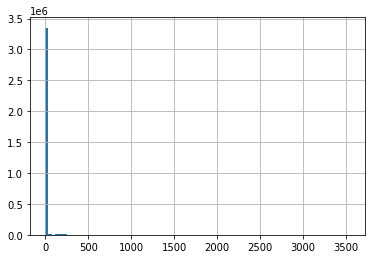

In [ ]:
df['Question Length'].hist(bins=100)

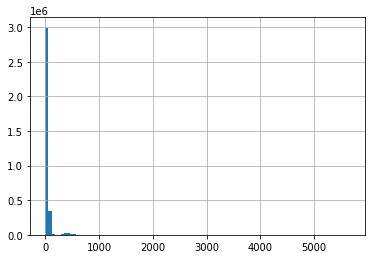

In [ ]:
df['Answer Length'].hist(bins=100)

In [ ]:
df_meta['Title Length'] = df_meta['Title'].str.split().apply(len)

In [ ]:
df_meta.head(60)

,ASIN,Title,Price,Image,Title Length
0,B00000J421,power wheels 6 volt rechargeable replacement b...,33.78,https://images-na.ssl-images-amazon.com/images...,7
1,B0000223J0,makita mak192629 7 7 inch hook and loop pad fo...,12.99,https://images-na.ssl-images-amazon.com/images...,13
2,B00002243Z,coleman cable 08666 16 feet heavy duty truck a...,37.41,https://images-na.ssl-images-amazon.com/images...,19
3,B00004Z78V,apc ups battery replacement for apc back ups m...,38.61,https://images-na.ssl-images-amazon.com/images...,12
4,B00005RHQQ,xantrex 802 1500 xpower 1 500 watt portable po...,516.95,https://images-na.ssl-images-amazon.com/images...,9
5,B00008RW9V,california car duster 62447 8b mini duster,6.00,https://images-na.ssl-images-amazon.com/images...,7
6,B00008RW9U,california car duster 62442 standard car duste...,19.99,https://images-na.ssl-images-amazon.com/images...,10
7,B00009PGNS,koolatron 18 qt compact cooler,6.13,https://images-na.ssl-images-amazon.com/images...,5
8,B00009YUK5,swagman original 4 towing bike rack,6.36,https://images-na.ssl-images-amazon.com/images...,6
9,B0000AVZMU,keeper 05654 bull ring anchor point universal ...,25.99,https://images-na.ssl-images-amazon.com/images...,15


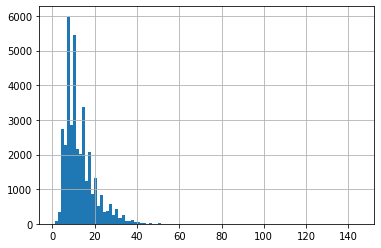

In [ ]:
df_meta['Title Length'].hist(bins=100)

#### 3.8. Removing some entries

In [ ]:
print('Total number of entries:', df.shape[0])
print('Maximum question length:', df['Question Length'].max())
print('Maximum answer length:', df['Answer Length'].max())
print('Number of questions with no answers after preprocessing:', df[df['Answer Length'] < 1].shape[0])
print('Number of answers with no questions after preprocessing:', df[df['Question Length'] < 1].shape[0])

Total number of entries: 3425040
Maximum question length: 3547
Maximum answer length: 5666
Number of questions with no answers after preprocessing: 2163
Number of answers with no questions after preprocessing: 203


In [ ]:
print('Total number of meta-entries:', df_meta.shape[0])
print('Maximum title length:', df_meta['Title Length'].max())
print('Lowest item price in $:', df_meta['Price'].min())
print('Highest item price in $:', df_meta['Price'].max())
print('Number of tiles with zero length after preprocessing:', df_meta[df_meta['Title Length'] < 1].shape[0])

Total number of meta-entries: 36969
Maximum title length: 145
Lowest item price in $: 0.01
Highest item price in $: 999.99
Number of tiles with zero length after preprocessing: 0


##### 3.8.1. Removing empty answers

In [ ]:
df = df[df['Answer Length'] > 0]
df.shape

(3422877, 6)

##### 3.8.2. Removing empty questions

In [ ]:
df = df[df['Question Length'] > 0]
df.shape

(3422674, 6)

##### 3.8.3. Removing answers of length more than three

In [ ]:
df = df[df['Answer Length'] < 4]
df.shape

(316389, 6)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
print('Total number of entries:', df.shape[0])
print('Maximum question length:', df['Question Length'].max())
print('Maximum answer length:', df['Answer Length'].max())

Total number of entries: 316389
Maximum question length: 1546
Maximum answer length: 3


In [ ]:
df['Questions Type'].value_counts()

open-ended    256648
yes/no         59741
Name: Questions Type, dtype: int64

##### 3.8.4. Removing questions of length more than eleven

In [ ]:
print("Average question length:", df['Question Length'].mean())

Average question length: 11.331607609619804


In [ ]:
df = df[df["Question Length"] < 12]
df.reset_index(drop=True, inplace=True)

In [ ]:
print("Shape of dataset:", df.shape)

Shape of dataset: (212155, 6)


In [ ]:
# Viewing an entry whose question length is eleven
print(df.iloc[7])
# Output 
# is this a set or do i have to order 2

ASIN                                          B00029WRJQ
Questions          is this a set or do i have to order 2
Questions Type                                open-ended
Answers                                          order 2
Question Length                                       11
Answer Length                                          2
Name: 7, dtype: object


In [ ]:
df.head(60)

,ASIN,Questions,Questions Type,Answers,Question Length,Answer Length
0,B000182CPM,is the hardware for installation included,yes/no,no,6,1
1,B000182F0Y,will they fit 2014 mazda 3 sport,yes/no,no,7,1
2,B000182F0Y,will they fit 2014 mazda 3 sport,yes/no,nope,7,1
3,B0001EW044,do they fit a 1998 gmc sierra 3 door,open-ended,yes,9,1
4,B00020BM32,will this product work with a 1995 buick rivera,yes/no,yes it will,9,3
5,B00027GTYC,will this work on the generation 1 alpha,open-ended,yes it will,8,3
6,B00029K1XK,is it easy to install,yes/no,very easy,5,2
7,B00029WRJQ,is this a set or do i have to order 2,open-ended,order 2,11,2
8,B0002F67ZK,it comes with door assembly,open-ended,yesterday,5,1
9,B0002F67ZK,is this a 12 volt igitor or 110,open-ended,yes 12 volt,8,3


##### 3.8.7. Removing title of length more than thirteen

In [ ]:
print("Shape of dataset:", df_meta.shape)

Shape of dataset: (36969, 5)


In [ ]:
print("Average title length:", df_meta['Title Length'].mean())

Average title length: 12.845870864778599


In [ ]:
df_meta = df_meta[df_meta['Title Length'] < 14]
df_meta.reset_index(drop=True, inplace=True)

In [ ]:
print("Shape of dataset:", df_meta.shape)

Shape of dataset: (23916, 5)


In [ ]:
df.to_csv('df_before_merge.csv', index=False)
df_meta.to_csv('df_meta_before_merge.csv', index=False)

In [ ]:
df = pd.read_csv('df_before_merge.csv')
print(df.shape)
df_meta = pd.read_csv('df_meta_before_merge.csv')
print(df_meta.shape)

(212155, 6)
(23916, 5)


##### 3.8.8. Removing duplicates from meta table

In [ ]:
print("Number of duplicates:", df_meta.duplicated().sum())

Number of duplicates: 1711


In [ ]:
print("Shape of data before removing the duplicates:", df_meta.shape)

Shape of data before removing the duplicates: (23916, 5)


In [ ]:
df_meta.drop_duplicates(inplace=True)
df_meta.reset_index(drop=True, inplace=True)

In [ ]:
print("Shape of data after removing the duplicates:", df_meta.shape)

Shape of data after removing the duplicates: (22205, 5)


#### 3.9. Merging the tables

In [ ]:
df_merged = pd.merge(df, df_meta, how='inner', on=['ASIN'])

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32366 entries, 0 to 32365
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ASIN             32366 non-null  object 
 1   Questions        32366 non-null  object 
 2   Questions Type   32366 non-null  object 
 3   Answers          32366 non-null  object 
 4   Question Length  32366 non-null  int64  
 5   Answer Length    32366 non-null  int64  
 6   Title            32366 non-null  object 
 7   Price            32366 non-null  float64
 8   Image            32366 non-null  object 
 9   Title Length     32366 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 2.7+ MB


In [ ]:
df_merged.head(60)

,ASIN,Questions,Questions Type,Answers,Question Length,Answer Length,Title,Price,Image,Title Length
0,B000182CPM,is the hardware for installation included,yes/no,no,6,1,dee zee dz1800 full size brite tread mud flaps,30.91,https://images-na.ssl-images-amazon.com/images...,9
1,B00027GTYC,will this work on the generation 1 alpha,open-ended,yes it will,8,3,sierra 18 2603 lower shift cable kit,63.86,https://images-na.ssl-images-amazon.com/images...,7
2,B00029WRJQ,is this a set or do i have to order 2,open-ended,order 2,11,2,cipa 11650 deluxe door mount towing mirror,58.98,https://images-na.ssl-images-amazon.com/images...,7
3,B0002JMFMA,will this fit a 2001 chevy malibu,open-ended,yes,7,1,gates 27041 windshield washer vacuum hose non ...,21.68,https://images-na.ssl-images-amazon.com/images...,8
4,B0002JMFMA,will this fit a 2001 chevy malibu,open-ended,yes it will,7,3,gates 27041 windshield washer vacuum hose non ...,21.68,https://images-na.ssl-images-amazon.com/images...,8
5,B0002OGJTA,will it have mirror pockets,open-ended,no mirror pockets,5,3,covercraft c40006 ready fit multibond car cover,100.60,https://images-na.ssl-images-amazon.com/images...,7
6,B0002RNSG4,does this fit jeep liberty,open-ended,yes it does,5,3,hopkins 42475 plug in simple vehicle wiring kit,28.13,https://images-na.ssl-images-amazon.com/images...,8
7,B0002YFD1K,does it test capacitors accurately,yes/no,yes and perfect,5,3,fluke 87 v digital multimeter,10.36,https://images-na.ssl-images-amazon.com/images...,5
8,B0002YFD1K,does it test capacitors accurately,yes/no,yes,5,1,fluke 87 v digital multimeter,10.36,https://images-na.ssl-images-amazon.com/images...,5
9,B0002YQSQO,can you get replacement filters from your loca...,yes/no,yes,10,1,goldenrod 495 bowl fuel tank filter with 1 npt...,34.99,https://images-na.ssl-images-amazon.com/images...,11


In [ ]:
print("Number of duplicates:", df_merged.duplicated().sum())

Number of duplicates: 0


##### 3.9.1. Analyzing images on merged table

In [ ]:
def decode_image(url):
  url_response = urllib.request.urlopen(url)
  img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
  img = cv2.imdecode(img_array, -1)
  return img

def load_images(image_paths):
  all_images_shape = dict()
  for url in image_paths:
    img = decode_image(url)
    all_images_shape[img.shape] = all_images_shape.get(img.shape, 0) + 1  
  return all_images_shape

In [ ]:
start_time = timer()
chunk_size = int(df_merged.shape[0] / 4)
df_subset = [df_merged.iloc[start:start + chunk_size, 8] for start in range(0, df_merged.shape[0], chunk_size)]
with Pool(len(df_subset)) as p:
  res_merged = p.map(load_images, df_subset)
  p.close()
  p.join()
timer(start_time)

Time taken: 0 hours 47 minutes and 34.57 seconds.


In [ ]:
image_shapes = dict()

for i in range(len(res_merged)):
  for (k,v) in res_merged[i].items():
    image_shapes[k] = image_shapes.get(k, 0) + v
    
image_shapes

{(36, 36, 3): 898,
 (40, 40): 6,
 (40, 40, 3): 29098,
 (50, 38, 3): 2307,
 (75, 19, 3): 1,
 (75, 37, 3): 4,
 (75, 54, 3): 3,
 (75, 56, 3): 3,
 (75, 60, 3): 6,
 (75, 70, 3): 2,
 (75, 75, 3): 2,
 (75, 88, 3): 1,
 (75, 89, 3): 2,
 (75, 90, 3): 3,
 (75, 91, 3): 3,
 (75, 92, 3): 8,
 (75, 94, 3): 2,
 (75, 97, 3): 6,
 (75, 100, 3): 1,
 (75, 102, 3): 2,
 (75, 105, 3): 2,
 (75, 111, 3): 3,
 (75, 120, 3): 3}

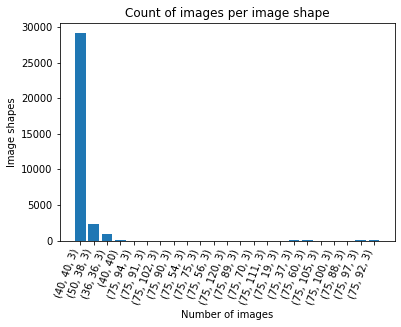

In [ ]:
plt.bar(range(len(image_shapes)), list(image_shapes.values()), align='center')
plt.xticks(range(len(image_shapes)), list(image_shapes.keys()), ha='right')
plt.xticks(rotation=70)
plt.title('Count of images per image shape')
plt.xlabel('Number of images')
plt.ylabel('Image shapes')
plt.show()

##### 3.9.2. Removing 2D images from merged table

In [ ]:
def decode_image(url):
  url_response = urllib.request.urlopen(url)
  img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
  img = cv2.imdecode(img_array, -1)
  return img

def load_images(image_paths):
  all_images = list()
  for url in image_paths:
    img = decode_image(url)
    if img.shape == (40, 40):
      all_images.append(url)
  return all_images

In [ ]:
start_time = timer()
chunk_size = int(df_merged.shape[0] / 10)
df_subset = [df_merged.iloc[start:start + chunk_size, 8] for start in range(0, df_merged.shape[0], chunk_size)]
with Pool(len(df_subset)) as p:
  res_merged_remove = p.map(load_images, df_subset)
  p.close()
  p.join()
timer(start_time)

Time taken: 0 hours 19 minutes and 8.15 seconds.


In [ ]:
images_to_remove = list()
for i in res_merged_remove:
  images_to_remove.extend(i)
len(images_to_remove)

6

In [ ]:
print('Merged table shape before removal of 2D images', df_merged.shape)
print()
for i in images_to_remove:
  df_merged.drop(df_merged.index[df_merged['Image'] == i], inplace = True)
print('Merged table shape after removal of 2D images', df_merged.shape)

Merged table shape before removal of 2D images (32366, 10)

Merged table shape after removal of 2D images (32360, 10)


(40, 40, 3)


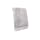

(40, 40, 3)


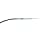

(40, 40, 3)


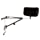

(40, 40, 3)


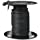

In [ ]:
# Some sample image visualization
for i in range(4):
  # Read image from web image
  image = io.imread(df_merged.iloc[i,8])

  print(image.shape)
  # Display image
  cv2_imshow(image)

##### 3.9.3. Viewing types of questions in merged table

In [ ]:
df_merged['Questions Type'].value_counts()

open-ended    25670
yes/no         6690
Name: Questions Type, dtype: int64

### 4. Saving the preprocessed dataset

In [ ]:
df_merged.to_csv('amazonqa_preprocessed.csv', index=False)

### 5. Data preparation

#### 5.1. Read the preprocessed data

In [ ]:
df = pd.read_csv('amazonqa_preprocessed.csv')

#### 5.2. Modify the dataset

In [ ]:
df['Answers'] = df['Answers'].apply(lambda x : '<start> '+ x + ' <end>')
df['QTA'] = df['Questions'].astype(str) + ' ' + df['Title'].astype(str)  + ' ' + df['Answers'].astype(str)
df

,ASIN,Questions,Questions Type,Answers,Question Length,Answer Length,Title,Price,Image,Title Length,QTA
0,B000182CPM,is the hardware for installation included,yes/no,<start> no <end>,6,1,dee zee dz1800 full size brite tread mud flaps,30.91,https://images-na.ssl-images-amazon.com/images...,9,is the hardware for installation included dee ...
1,B00027GTYC,will this work on the generation 1 alpha,open-ended,<start> yes it will <end>,8,3,sierra 18 2603 lower shift cable kit,63.86,https://images-na.ssl-images-amazon.com/images...,7,will this work on the generation 1 alpha sierr...
2,B00029WRJQ,is this a set or do i have to order 2,open-ended,<start> order 2 <end>,11,2,cipa 11650 deluxe door mount towing mirror,58.98,https://images-na.ssl-images-amazon.com/images...,7,is this a set or do i have to order 2 cipa 116...
3,B0002JMFMA,will this fit a 2001 chevy malibu,open-ended,<start> yes <end>,7,1,gates 27041 windshield washer vacuum hose non ...,21.68,https://images-na.ssl-images-amazon.com/images...,8,will this fit a 2001 chevy malibu gates 27041 ...
4,B0002JMFMA,will this fit a 2001 chevy malibu,open-ended,<start> yes it will <end>,7,3,gates 27041 windshield washer vacuum hose non ...,21.68,https://images-na.ssl-images-amazon.com/images...,8,will this fit a 2001 chevy malibu gates 27041 ...
...,...,...,...,...,...,...,...,...,...,...,...
32355,B00DJYTGYU,how long is the wire,open-ended,<start> 9 10 ft <end>,5,3,pdp battlefield 4 wired controller xbox 360,6.04,https://images-na.ssl-images-amazon.com/images...,7,how long is the wire pdp battlefield 4 wired c...
32356,B00DJYTGYU,how long is the wire,open-ended,<start> around 10 feet <end>,5,3,pdp battlefield 4 wired controller xbox 360,6.04,https://images-na.ssl-images-amazon.com/images...,7,how long is the wire pdp battlefield 4 wired c...
32357,B00DJYTGYU,would this controller work on a ps4,open-ended,<start> nope <end>,7,1,pdp battlefield 4 wired controller xbox 360,6.04,https://images-na.ssl-images-amazon.com/images...,7,would this controller work on a ps4 pdp battle...
32358,B00DJYTGYU,does this controller have sixaxis support thanks,open-ended,<start> yes it does <end>,7,3,pdp battlefield 4 wired controller xbox 360,6.04,https://images-na.ssl-images-amazon.com/images...,7,does this controller have sixaxis support than...


In [ ]:
df.to_csv('amazonqa_preprocessed_modified.csv', index=False)

In [ ]:
df_train = df[['Questions', 'Title', 'Price', 'Image']]

#### 5.3. Split the dataset

In [ ]:
enc_in_train, enc_in_test, qa_train, qa_test, dec_in_train, dec_in_test = train_test_split(df_train, df['QTA'], df['Answers'], test_size=0.031, random_state=SEED)
enc_in_train, enc_in_val, qa_train, qa_val, dec_in_train, dec_in_val = train_test_split( enc_in_train, qa_train, dec_in_train, test_size=0.2, random_state=SEED)

#### 5.4. Preparing text features - questions, answers, title

###### 5.4.1. Tokenize the text sequences

In [ ]:
def create_tokenizer(lines):
  """
    Fit a tokenizer
  """
  tokenizer = Tokenizer(filters='')
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
qa_tokenizer = create_tokenizer(df['QTA'])
qa_vocab_size = len(qa_tokenizer.word_index) + 1
ques_length = df['Question Length'].max()
title_length = df['Title Length'].max()
ans_length = df['Answer Length'].max()
print('Questions, Answers and Title Vocabulary Size: %d' % qa_vocab_size)
print('Questions Max Length: %d' % (ques_length))
print('Answers Max Length: %d' % (ans_length))
print('Title Max Length: %d' % (title_length))

Questions, Answers and Title Vocabulary Size: 29576
Questions Max Length: 11
Answers Max Length: 3
Title Max Length: 13


In [ ]:
# saving tokenizer
with open('qa_tokenizer', 'wb') as handle:
    pickle.dump(qa_tokenizer, handle)

###### 5.4.2. Encode and pad the text sequences

In [ ]:
def encode_sequences(tokenizer, length, lines):
  """
    Encode and pad sequences
  """
  # Integer encode sequences
  X = tokenizer.texts_to_sequences(lines)
  # Pad sequences with 0 values
  X = pad_sequences(X, maxlen=length, padding='post')
  return X

In [ ]:
print('>> Before')
print('> Shape')
print('enc_in_train:', enc_in_train.shape)
print('enc_in_val:', enc_in_val.shape)
print('enc_in_test:', enc_in_test.shape)
print('dec_in_train:', dec_in_train.shape)
print('dec_in_val:', dec_in_val.shape)
print('dec_in_test:', dec_in_test.shape)

enc_in_ques_train = encode_sequences(qa_tokenizer, ques_length, enc_in_train['Questions'])
enc_in_ques_val = encode_sequences(qa_tokenizer, ques_length, enc_in_val['Questions'])
enc_in_ques_test = encode_sequences(qa_tokenizer, ques_length, enc_in_test['Questions'])

enc_in_title_train = encode_sequences(qa_tokenizer, title_length, enc_in_train['Title'])
enc_in_title_val = encode_sequences(qa_tokenizer, title_length, enc_in_val['Title'])
enc_in_title_test = encode_sequences(qa_tokenizer, title_length, enc_in_test['Title'])

dec_in_train = encode_sequences(qa_tokenizer, ans_length+2, dec_in_train)
dec_in_val = encode_sequences(qa_tokenizer, ans_length+2, dec_in_val)
dec_in_test = encode_sequences(qa_tokenizer, ans_length+2, dec_in_test)

print('\n\n>> After')
print('> Shape')
print('enc_in_ques_train:', enc_in_ques_train.shape)
print('enc_in_ques_val:', enc_in_ques_val.shape)
print('enc_in_ques_test:', enc_in_ques_test.shape)
print('enc_in_title_train:', enc_in_title_train.shape)
print('enc_in_title_val:', enc_in_title_val.shape)
print('enc_in_title_test:', enc_in_title_test.shape)
print('dec_in_train:', dec_in_train.shape)
print('dec_in_val:', dec_in_val.shape)
print('dec_in_test:', dec_in_test.shape)

>> Before
> Shape
enc_in_train: (25084, 4)
enc_in_val: (6272, 4)
enc_in_test: (1004, 4)
dec_in_train: (25084,)
dec_in_val: (6272,)
dec_in_test: (1004,)


>> After
> Shape
enc_in_ques_train: (25084, 11)
enc_in_ques_val: (6272, 11)
enc_in_ques_test: (1004, 11)
enc_in_title_train: (25084, 13)
enc_in_title_val: (6272, 13)
enc_in_title_test: (1004, 13)
dec_in_train: (25084, 5)
dec_in_val: (6272, 5)
dec_in_test: (1004, 5)


###### 5.4.3. Create lookup maps

In [ ]:
qa_vocab = qa_tokenizer.word_index
word2id = dict()
id2word = dict()
for k, v in qa_vocab.items():
    word2id[k] = v
    id2word[v] = k
print('Size of word2id:', len(word2id))
print('Size of id2word:', len(id2word))

Size of word2id: 29575
Size of id2word: 29575


###### 5.4.4. Load pretrained word embeddings

In [ ]:
!wget -qq https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

In [ ]:
!unzip -qq wiki-news-300d-1M.vec.zip

In [ ]:
# load the pre-trained word-embedding vectors 
embeddings_index = dict()
for i, line in enumerate(open('wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = asarray(values[1:], dtype='float32')
    
print('Found %s word vectors' % len(embeddings_index))

Found 999995 word vectors


###### 5.4.5. Generate word embeddings

In [ ]:
# create token-embedding mapping
embedding_matrix = zeros((qa_vocab_size, 300))
for word, i in qa_vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print(embedding_matrix.shape)

(29576, 300)


In [ ]:
save('embedding_matrix', embedding_matrix)

In [ ]:
embedding_matrix = load('embedding_matrix.npy')

##### 5.5. Preparing numerical features - price

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
enc_in_price_train = sc.fit_transform(enc_in_train['Price'].values.reshape(-1, 1))
enc_in_price_val = sc.transform (enc_in_val['Price'].values.reshape(-1, 1))
enc_in_price_test = sc.transform (enc_in_test['Price'].values.reshape(-1, 1))

print('> Shape')
print('enc_in_price_train:', enc_in_price_train.shape)
print('enc_in_price_val:', enc_in_price_val.shape)
print('enc_in_price_test:', enc_in_price_test.shape)

> Shape
enc_in_price_train: (25084, 1)
enc_in_price_val: (6272, 1)
enc_in_price_test: (1004, 1)


In [ ]:
with open('sc', 'wb') as handle:
    pickle.dump(sc, handle)

##### 5.6. Preparing image features - image

In [ ]:
def normalize(img):
  # Normalize pixel values to be between 0 and 1
  img = img / 255.0
  return img

def decode_image(url):
  url_response = urllib.request.urlopen(url)
  img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
  img = cv2.imdecode(img_array, -1)
  img = cv2.resize(img, (40, 40), interpolation=cv2.INTER_NEAREST)
  return img

def load_images(image_paths):
  all_images = []
  for url in image_paths:
    img = decode_image(url)
    img = normalize(img)
    all_images.append(img)
  return all_images

In [ ]:
start_time = timer()
chunk_size = int(enc_in_test.shape[0] / 10)
df_subset = [enc_in_test.iloc[start:start + chunk_size, 3] for start in range(0, enc_in_test.shape[0], chunk_size)]
with Pool(len(df_subset)) as p:
  res_test = p.map(load_images, df_subset)
  p.close()
  p.join()
timer(start_time)

Time taken: 0 hours 2 minutes and 17.41 seconds.


In [ ]:
start_time = timer()
chunk_size = int(enc_in_val.shape[0] / 10)
df_subset = [enc_in_val.iloc[start:start + chunk_size, 3] for start in range(0, enc_in_val.shape[0], chunk_size)]
with Pool(len(df_subset)) as p:
  res_val = p.map(load_images, df_subset)
  p.close()
  p.join()
timer(start_time)

Time taken: 0 hours 5 minutes and 23.99 seconds.


In [ ]:
start_time = timer()
chunk_size = int(enc_in_train.shape[0] / 10)
df_subset = [enc_in_train.iloc[start:start + chunk_size, 3] for start in range(0, enc_in_train.shape[0], chunk_size)]
with Pool(len(df_subset)) as p:
  res_train = p.map(load_images, df_subset)
  p.close()
  p.join()
timer(start_time)

Time taken: 0 hours 18 minutes and 0.16 seconds.


In [ ]:
def merge_list(mList):
  temp = []
  for i in mList:
    temp.extend(i)
  return np.stack( temp, axis=0 )
  
enc_in_image_train = merge_list(res_train)
enc_in_image_val = merge_list(res_val)
enc_in_image_test = merge_list(res_test)

print('> Shape')
print('enc_in_image_train:', enc_in_image_train.shape)
print('enc_in_image_val:', enc_in_image_val.shape)
print('enc_in_image_test:', enc_in_image_test.shape)

> Shape
enc_in_image_train: (25084, 40, 40, 3)
enc_in_image_val: (6272, 40, 40, 3)
enc_in_image_test: (1004, 40, 40, 3)


In [ ]:
save('enc_in_ques_train', enc_in_ques_train)
save('enc_in_ques_val', enc_in_ques_val)
save('enc_in_ques_test', enc_in_ques_test)
save('enc_in_title_train', enc_in_title_train)
save('enc_in_title_val', enc_in_title_val)
save('enc_in_title_test', enc_in_title_test)
save('enc_in_price_train', enc_in_price_train)
save('enc_in_price_val', enc_in_price_val)
save('enc_in_price_test', enc_in_price_test)
save('enc_in_image_train', enc_in_image_train)
save('enc_in_image_val', enc_in_image_val)
save('enc_in_image_test', enc_in_image_test)
save('dec_in_train', dec_in_train)
save('dec_in_val', dec_in_val)
save('dec_in_test', dec_in_test)

In [ ]:
!tar cvzf enc-dec.tar.gz ./enc_in_ques_train.npy ./enc_in_ques_val.npy ./enc_in_ques_test.npy ./enc_in_title_train.npy ./enc_in_title_val.npy ./enc_in_title_test.npy ./enc_in_price_train.npy ./enc_in_price_val.npy ./enc_in_price_test.npy ./enc_in_image_train.npy ./enc_in_image_val.npy ./enc_in_image_test.npy ./dec_in_train.npy ./dec_in_val.npy ./dec_in_test.npy 

./enc_in_ques_train.npy
./enc_in_ques_val.npy
./enc_in_ques_test.npy
./enc_in_title_train.npy
./enc_in_title_val.npy
./enc_in_title_test.npy
./enc_in_price_train.npy
./enc_in_price_val.npy
./enc_in_price_test.npy
./enc_in_image_train.npy
./enc_in_image_val.npy
./enc_in_image_test.npy
./dec_in_train.npy
./dec_in_val.npy
./dec_in_test.npy


In [ ]:
!tar xvzf enc-dec.tar.gz .

./enc_in_ques_train.npy
./enc_in_ques_val.npy
./enc_in_ques_test.npy
./enc_in_title_train.npy
./enc_in_title_val.npy
./enc_in_title_test.npy
./enc_in_price_train.npy
./enc_in_price_val.npy
./enc_in_price_test.npy
./enc_in_image_train.npy
./enc_in_image_val.npy
./enc_in_image_test.npy
./dec_in_train.npy
./dec_in_val.npy
./dec_in_test.npy


In [ ]:
enc_in_ques_train = load('enc_in_ques_train.npy')
enc_in_ques_val = load('enc_in_ques_val.npy')
enc_in_ques_test = load('enc_in_ques_test.npy')
enc_in_title_train = load('enc_in_title_train.npy')
enc_in_title_val = load('enc_in_title_val.npy')
enc_in_title_test = load('enc_in_title_test.npy')
enc_in_price_train = load('enc_in_price_train.npy')
enc_in_price_val = load('enc_in_price_val.npy')
enc_in_price_test = load('enc_in_price_test.npy')
enc_in_image_train = load('enc_in_image_train.npy')
enc_in_image_val = load('enc_in_image_val.npy')
enc_in_image_test = load('enc_in_image_test.npy')
dec_in_train = load('dec_in_train.npy')
dec_in_val = load('dec_in_val.npy')
dec_in_test = load('dec_in_test.npy')

### 6. Modeling

#### 6.1. Baseline Model

##### 6.1.1. Create a tf.data dataset

In [ ]:
BATCH_SIZE = 32
embedding_dim = 300
units = 1024
max_ques_length = ques_length
max_title_length = title_length
max_ans_length = ans_length + 2 # +2 for start and end token

In [ ]:
BUFFER_SIZE_TRAIN = len(enc_in_train)
steps_per_epoch_train = BUFFER_SIZE_TRAIN//BATCH_SIZE

dataset_train = tf.data.Dataset.from_tensor_slices((enc_in_ques_train, enc_in_title_train, enc_in_price_train, enc_in_image_train, dec_in_train)).shuffle(BUFFER_SIZE_TRAIN)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
BUFFER_SIZE_VAL = len(enc_in_val)
steps_per_epoch_val = BUFFER_SIZE_VAL//BATCH_SIZE

dataset_val = tf.data.Dataset.from_tensor_slices((enc_in_ques_val, enc_in_title_val, enc_in_price_val, enc_in_image_val, dec_in_val)).shuffle(BUFFER_SIZE_VAL)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_ques_batch, example_input_title_batch, example_input_price_batch, example_input_image_batch, example_target_batch = next(iter(dataset_train))
example_input_ques_batch.shape, example_input_title_batch.shape, example_input_price_batch.shape, example_input_image_batch.shape, example_target_batch.shape

(TensorShape([32, 11]),
 TensorShape([32, 13]),
 TensorShape([32, 1]),
 TensorShape([32, 40, 40, 3]),
 TensorShape([32, 5]))

##### 6.1.2. Write the encoder and decoder model

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding_ques = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_ques_length, 
                                                   weights=[embedding_matrix], trainable=False)
        self.embedding_title = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_title_length, 
                                                   weights=[embedding_matrix], trainable=False)
        
        self.lstm_ques = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True)
        self.lstm_title = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True)
        
        self.dense_state_h_ques = tf.keras.layers.Dense(int(self.enc_units/2))
        self.dense_state_h_title = tf.keras.layers.Dense(int(self.enc_units/2))
        self.dense_state_c_ques = tf.keras.layers.Dense(int(self.enc_units/2))
        self.dense_state_c_title = tf.keras.layers.Dense(int(self.enc_units/2))

        self.conv2d_image = tf.keras.layers.Conv2D(32, (3, 3), 
                                    activation = 'relu',
                                    kernel_initializer = tf.keras.initializers.HeNormal(seed=SEED),
                                    padding = 'same')
        self.flatten_image = tf.keras.layers.Flatten()
        self.dense_image = tf.keras.layers.Dense(self.enc_units)

        self.dense_price = tf.keras.layers.Dense(self.enc_units)
      
    def call(self, x):   
        question, title, price, image, hidden = x[0], x[1], x[2], x[3], x[4]
        # question shape == (batch_size, max_ques_length)
        # title shape == (batch_size, max_title_length)
        # price shape == (batch_size, 1)
        # image shape == (batch_size, img_width, img_height, channels)

        question = self.embedding_ques(question)
        # question shape == (batch_size, max_ques_length, embedding_dim)
        output_ques, state_h_ques, state_c_ques = self.lstm_ques(question, initial_state = hidden)
        # output_ques shape == (batch_size, max_ques_length, enc_units)
        # state_h_ques shape == (batch_size, enc_units)
        # state_c_ques shape == (batch_size, enc_units)

        title = self.embedding_title(title)
        # title shape == (batch_size, max_title_length, embedding_dim)
        output_title, state_h_title, state_c_title = self.lstm_title(title, initial_state = hidden)
        # output_title shape == (batch_size, max_title_length, enc_units)
        # state_h_title shape == (batch_size, enc_units)
        # state_c_title shape == (batch_size, enc_units)

        price = self.dense_price(price)
        # price shape == (batch_size, enc_units)

        image = self.conv2d_image(image)
        # image shape ==  (batch_size, img_width, img_height, filters=32)
        image = self.flatten_image(image)
        # image shape == (batch_size, 51200)
        image = self.dense_image(image)
        # image shape == (batch_size, enc_units)
        
        output = tf.concat([output_ques, output_title], axis=1)
        # output shape == (batch_size, max_ques_length + max_title_length, enc_units)
        output = tf.concat([tf.expand_dims(price, 1), output], axis=1)
        # output shape == (batch_size, max_ques_length + max_title_length + 1, enc_units)
        output = tf.concat([tf.expand_dims(image, 1), output], axis=1)
        # output shape == (batch_size, max_ques_length + max_title_length + 1 + 1, enc_units)

        state_h_ques = self.dense_state_h_ques(state_h_ques)
        # state_h_ques shape == (batch_size, int(enc_units/2))
        state_h_title = self.dense_state_h_title(state_h_title)
        # state_h_title shape == (batch_size, int(enc_units/2))
        state_h = tf.concat([state_h_ques, state_h_title], axis=-1)
        # state_h shape == (batch_size, enc_units)

        state_c_ques = self.dense_state_c_ques(state_c_ques)
        # state_c_ques shape == (batch_size, int(enc_units/2))
        state_c_title = self.dense_state_c_title(state_c_title)
        # state_c_title shape == (batch_size, int(enc_units/2))
        state_c = tf.concat([state_c_ques, state_c_title], axis=-1)
        # state_c shape == (batch_size, enc_units + enc_units)

        return output, state_h, state_c

    def initialize_hidden_state(self):
        return (tf.zeros((self.batch_sz, self.enc_units)),
                tf.zeros((self.batch_sz, self.enc_units)))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_ans_length, 
                                                   weights=[embedding_matrix], trainable=False)
        self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, y):   
        x, hidden, enc_output = y[0], y[1], y[2]
        # x shape == (batch_size, 1)
        # hidden shape == tuple of two (batch_size, enc_units+enc_units)
        # enc_output shape == (batch_size, max_ques_length, enc_units)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x, initial_state=hidden)
        # output shape == (batch_size, 1, dec_units)
        # state_h shape == (batch_size, dec_units)
        # state_c shape == (batch_size, dec_units)
 
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size * 1, dec_units)
        
        x = self.fc(output)
        # output shape == (batch_size, vocab)
        
        return x, state_h, state_c

        
    def initialize_hidden_state(self):
        return (tf.zeros((self.batch_sz, self.dec_units)),
                tf.zeros((self.batch_sz, self.dec_units)))

In [ ]:
encoder = Encoder(qa_vocab_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_state_hidden, sample_state_cell = encoder([example_input_ques_batch, example_input_title_batch, example_input_price_batch, example_input_image_batch, sample_hidden])
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder hidden state shape: (batch size, units) {}'.format(sample_state_hidden.shape))
print ('Encoder cell state shape: (batch size, units) {}'.format(sample_state_cell.shape))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Encoder output shape: (batch size, sequence length, units) (32, 26, 1024)
Encoder hidden state shape: (batch size, units) (32, 1024)
Encoder cell state shape: (batch size, units) (32, 1024)


In [ ]:
encoder.summary()

Model: "encoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     multiple                  8872800   
_________________________________________________________________
embedding_13 (Embedding)     multiple                  8872800   
_________________________________________________________________
lstm_12 (LSTM)               multiple                  5427200   
_________________________________________________________________
lstm_13 (LSTM)               multiple                  5427200   
_________________________________________________________________
dense_28 (Dense)             multiple                  524800    
_________________________________________________________________
dense_29 (Dense)             multiple                  524800    
_________________________________________________________________
dense_30 (Dense)             multiple                  52

In [ ]:
decoder = Decoder(qa_vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder([tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output])

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 29576)


In [ ]:
decoder.summary()

Model: "decoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     multiple                  8872800   
_________________________________________________________________
lstm_14 (LSTM)               multiple                  5427200   
_________________________________________________________________
dense_34 (Dense)             multiple                  30315400  
Total params: 44,615,400
Trainable params: 35,742,600
Non-trainable params: 8,872,800
_________________________________________________________________


##### 6.1.3. Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

##### 6.1.4. Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './baseline_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

##### 6.1.5. Setup TensorBoard logging

In [ ]:
if not os.path.exists('logs'):
  os.makedirs('logs')
else:
  shutil.rmtree('logs', ignore_errors=True)
  os.makedirs('logs')

In [ ]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/gradient_tape/' + current_time + '/baseline'
summary_writer = tf.summary.create_file_writer(log_dir)

##### 6.1.6. Training
1.   Pass the input through the encoder which return encoder output and the encoder hidden state.
2.   The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
3.   The decoder returns the predictions and the decoder hidden state.
4.   The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5.   Use teacher forcing to decide the next input to the decoder.
6.   Teacher forcing is the technique where the target word is passed as the next input to the decoder.
7.   The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
@tf.function
def train_step(inp_ques, inp_title, inp_price, inp_img, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_outputs = encoder([inp_ques, inp_title, inp_price, inp_img, enc_hidden])

    enc_output = enc_outputs[0]

    enc_states = enc_outputs[1:]

    dec_state_h, dec_state_c = enc_states

    dec_input = tf.expand_dims([word2id['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_state_h, dec_state_c = \
                      decoder([dec_input, (dec_state_h, dec_state_c), enc_output])

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

In [ ]:
def train(EPOCHS):
  loss_train = list()
  loss_val = list()

  for epoch in range(EPOCHS):
      # Training
      start_time = timer()
      print("----- Training -----")
      enc_hidden_train = encoder.initialize_hidden_state()
      total_loss_train = 0

      for (batch, (inp_ques, inp_title, inp_price, inp_img, targ)) in enumerate(dataset_train.take(steps_per_epoch_train)):
        batch_loss = train_step(inp_ques, inp_title, inp_price, inp_img, targ, enc_hidden_train)
        total_loss_train += batch_loss

        if batch % 100 == 0:
          print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                      batch,
                                                      batch_loss.numpy()))
      
      print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                          total_loss_train / steps_per_epoch_train))
      
      temp_loss_train = total_loss_train / steps_per_epoch_train
      loss_train.append(temp_loss_train)
      with summary_writer.as_default():
          tf.summary.scalar('loss', temp_loss_train, step=epoch)

      timer(start_time)
      
      # Validation
      start_time = timer()
      print("----- Validation -----")
      enc_hidden_val = encoder.initialize_hidden_state()
      total_loss_val = 0

      for (batch, (inp_ques, inp_title, inp_price, inp_img, targ)) in enumerate(dataset_val.take(steps_per_epoch_val)):
        batch_loss = train_step(inp_ques, inp_title, inp_price, inp_img, targ, enc_hidden_val)
        total_loss_val += batch_loss

        if batch % 40 == 0:
          print('Epoch {} Batch {} Val-Loss {:.4f}'.format(epoch + 1,
                                                      batch,
                                                      batch_loss.numpy()))
      
      print('Epoch {} Val-Loss {:.4f}'.format(epoch + 1,
                                          total_loss_val / steps_per_epoch_val))
      
      # saving (checkpoint) the model every 10 epochs
      if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

      temp_loss_val = total_loss_val / steps_per_epoch_val
      loss_val.append(temp_loss_val)
      with summary_writer.as_default():
          tf.summary.scalar('val-loss', temp_loss_val, step=epoch)

      if epoch == EPOCHS-1:
        for (batch, (inp_ques, inp_title, inp_price, inp_img, targ)) in enumerate(dataset_val.take(1)):
          # Bracket the function call with
          # tf.summary.trace_on() and tf.summary.trace_export().
          tf.summary.trace_on(graph=True, profiler=True)
          batch_loss = train_step(inp_ques, inp_title, inp_price, inp_img, targ, enc_hidden_val)
          with summary_writer.as_default():
              tf.summary.trace_export(
                  name="step",
                  step=0,
                  profiler_outdir=log_dir)

      timer(start_time)
  return loss_train, loss_val

In [ ]:
start_time = timer()
loss_train, loss_val = train(EPOCHS)
timer(start_time)

----- Training -----
Epoch 1 Batch 0 Loss 8.2336
Epoch 1 Batch 100 Loss 2.0272
Epoch 1 Batch 200 Loss 2.7035
Epoch 1 Batch 300 Loss 2.6317
Epoch 1 Batch 400 Loss 2.6091
Epoch 1 Batch 500 Loss 2.2373
Epoch 1 Batch 600 Loss 2.0692
Epoch 1 Batch 700 Loss 2.5774
Epoch 1 Loss 2.3366
Time taken: 0 hours 0 minutes and 37.84 seconds.
----- Validation -----
Epoch 1 Batch 0 Val-Loss 1.5437
Epoch 1 Batch 40 Val-Loss 1.6149
Epoch 1 Batch 80 Val-Loss 2.6273
Epoch 1 Batch 120 Val-Loss 1.9034
Epoch 1 Batch 160 Val-Loss 1.7842
Epoch 1 Val-Loss 2.1083
Time taken: 0 hours 0 minutes and 8.06 seconds.
----- Training -----
Epoch 2 Batch 0 Loss 1.9318
Epoch 2 Batch 100 Loss 1.8110
Epoch 2 Batch 200 Loss 2.4534
Epoch 2 Batch 300 Loss 1.4970
Epoch 2 Batch 400 Loss 1.6199
Epoch 2 Batch 500 Loss 2.0904
Epoch 2 Batch 600 Loss 2.0115
Epoch 2 Batch 700 Loss 1.8290
Epoch 2 Loss 1.9284
Time taken: 0 hours 0 minutes and 31.78 seconds.
----- Validation -----
Epoch 2 Batch 0 Val-Loss 1.7464
Epoch 2 Batch 40 Val-Loss 2.

##### 6.1.7. Save the model

In [ ]:
encoder.save_weights('baseline_encoder_weights.h5')
decoder.save_weights('baseline_decoder_weights.h5')

In [ ]:
!tar cvzf baseline_checkpoints.tar.gz ./baseline_checkpoints/checkpoint ./baseline_checkpoints/ckpt-1.data-00000-of-00001 ./baseline_checkpoints/ckpt-1.index ./baseline_encoder_weights.h5 ./baseline_decoder_weights.h5

./baseline_checkpoints/checkpoint
./baseline_checkpoints/ckpt-1.data-00000-of-00001
./baseline_checkpoints/ckpt-1.index
./baseline_encoder_weights.h5
./baseline_decoder_weights.h5


In [ ]:
ENC_SAVED_MODEL_DIR = 'baseline_encoder'
DEC_SAVED_MODEL_DIR = 'baseline_decoder'
TFLITE_MODELS_DIR = 'baseline_tflite_models'
ENC_TFLITE_MODEL_NAME = 'baseline_encoder'
DEC_TFLITE_MODEL_NAME = 'baseline_decoder'
ENC_TFLITE_QUANTIZED_MODEL_NAME = 'baseline_encoder_f16'
DEC_TFLITE_QUANTIZED_MODEL_NAME = 'baseline_decoder_f16'

In [ ]:
encoder.save(ENC_SAVED_MODEL_DIR)
decoder.save(DEC_SAVED_MODEL_DIR)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: baseline_encoder/assets
INFO:tensorflow:Assets written to: baseline_decoder/assets


In [ ]:
import pathlib
def prepare_tflite_models_dir(dir_name):
  tflite_models_dir = pathlib.Path(os.path.join(os.getcwd(), dir_name))
  tflite_models_dir.mkdir(exist_ok=True, parents=True)
  return tflite_models_dir

def convert_saved_model_to_tflite(saved_models_dir, tflite_models_dir, tflite_model_name, quantize=False):
  # convert the SavedModel into a TensorFlow Lite model
  converter = tf.lite.TFLiteConverter.from_saved_model(saved_models_dir)
  if quantize:
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
  tflite_model = converter.convert()
  
  tflite_model_file = tflite_models_dir/"{}".format(tflite_model_name)
  tflite_model_file.write_bytes(tflite_model)
  return tflite_model_file

In [ ]:
tflite_models_dir = prepare_tflite_models_dir(TFLITE_MODELS_DIR)
tflite_encoder_model_file = convert_saved_model_to_tflite(ENC_SAVED_MODEL_DIR, tflite_models_dir, ENC_TFLITE_MODEL_NAME)
tflite_decoder_model_file = convert_saved_model_to_tflite(DEC_SAVED_MODEL_DIR, tflite_models_dir, DEC_TFLITE_MODEL_NAME)
tflite_encoder_model_fp16_file = convert_saved_model_to_tflite(ENC_SAVED_MODEL_DIR, tflite_models_dir, ENC_TFLITE_QUANTIZED_MODEL_NAME, quantize=True)
tflite_decoder_model_fp16_file = convert_saved_model_to_tflite(DEC_SAVED_MODEL_DIR, tflite_models_dir, DEC_TFLITE_QUANTIZED_MODEL_NAME, quantize=True)

In [ ]:
# Print tf-lite model sizes
!ls -lh {tflite_models_dir}

total 681M
-rw-r--r-- 1 root root 171M Aug 15 11:45 baseline_decoder
-rw-r--r-- 1 root root  86M Aug 15 11:46 baseline_decoder_f16
-rw-r--r-- 1 root root 284M Aug 15 11:45 baseline_encoder
-rw-r--r-- 1 root root 142M Aug 15 11:46 baseline_encoder_f16


##### 6.1.8. Plot the model's loss

In [ ]:
def plot_loss(EPOCHS, loss_train, loss_val):
  epochs = range(EPOCHS)
  plt.plot(epochs, loss_train, 'b', label='Training loss')
  plt.plot(epochs, loss_val, 'r', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Sparse categorical crossentropy loss')
  plt.legend()
  plt.show()

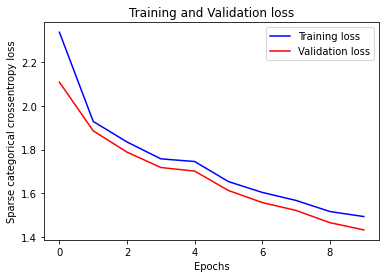

In [ ]:
plot_loss(EPOCHS, loss_train, loss_val)

##### 6.1.9. Inference
1.   The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
2.   Stop predicting when the model predicts the end token.

###### 6.1.9.1. Without TF-Lite

In [ ]:
## Beam search
def evaluate_beam(inputs_ques, inputs_title, inputs_price, inputs_image, 
                  encoder, decoder, max_length_inp_ques, max_length_inp_title, 
                  max_length_targ, special_input=False, beam_index=3):
    """
      inputs_ques type = numpy.ndarray 
      inputs_ques shape = (1, max_length_inp_ques)
      inputs_title type = numpy.ndarray 
      inputs_title shape = (1, max_length_inp_title)
      inputs_price type = numpy.ndarray 
      inputs_price shape = (1, 1)
      inputs_image type = numpy.ndarray 
      inputs_image shape = (1, image_width, image_height, channels)
    """
    if special_input:
      inputs_ques = tf.zeros((1, max_length_inp_ques), dtype=tf.dtypes.int32)
      inputs_title = tf.zeros((1, max_length_inp_title), dtype=tf.dtypes.int32)
      inputs_price = tf.zeros((1, 1), dtype=tf.dtypes.int32)
      inputs_image = tf.zeros((1, 40, 40, 3), dtype=tf.dtypes.float32)
      sentence = 'All zeros'
    else:
      sentence = ''
      for i in inputs_ques[0]:
          if i == 0: # break if post padding detected
              break
          sentence = sentence + id2word[i] + ' '
      inputs_ques = tf.convert_to_tensor(inputs_ques)
      inputs_title = tf.convert_to_tensor(inputs_title)
      inputs_price = tf.convert_to_tensor(inputs_price)
      inputs_image = tf.convert_to_tensor(inputs_image)

    start = [word2id['<start>']]
    
    # result[0][0] = index of the starting word
    # result[0][1] = probability of the word predicted
    result = [[start, 0.0]]

    enc_hidden = (tf.zeros((1, units)), tf.zeros((1, units)))
    enc_outputs = encoder([inputs_ques, inputs_title, inputs_price, inputs_image, enc_hidden])
    enc_output = enc_outputs[0]
    enc_states = enc_outputs[1:]
    dec_state_h, dec_state_c = enc_states
    dec_input = tf.expand_dims([word2id['<start>']], 0)

    # (max_length_targ-1) because start token is already added in the result
    while len(result[0][0]) < (max_length_targ-1):
        temp = []
        for s in result:

          predictions, dec_state_h, dec_state_c = \
                      decoder([dec_input, (dec_state_h, dec_state_c), enc_output])

         
          
          # Getting the top <beam_index>(n) predictions
          word_preds = np.argsort(predictions[0])[-beam_index:]
          
          # creating a new list so as to put them via the model again
          for w in word_preds:       
            next_cap, prob = s[0][:], s[1]
            next_cap.append(w)
            prob += predictions[0][w]
            temp.append([next_cap, prob])
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]
        
        predicted_id = result[-1] # with Max Probability
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 

        if(prd_id!=word2id['<end>']):
          dec_input = tf.expand_dims([prd_id], 0)  # Decoder input is the word predicted with highest probability among the top_k words predicted
        else:
          break

    result = result[-1][0]
    
    intermediate_result = [id2word[i] for i in result]
    
    final_result = []
    for i in intermediate_result:
        if i != '<end>':
            final_result.append(i)
        else:
            break

    
    final_result = ' '.join(final_result[1:])
    return final_result, sentence

In [ ]:
## Greedy search
def evaluate(inputs_ques, inputs_title, inputs_price, inputs_image, encoder, 
             decoder, max_length_inp_ques, max_length_inp_title,
             max_length_targ, special_input=False):
    """
      inputs_ques type = numpy.ndarray 
      inputs_ques shape = (1, max_length_inp_ques)
      inputs_title type = numpy.ndarray 
      inputs_title shape = (1, max_length_inp_title)
      inputs_price type = numpy.ndarray 
      inputs_price shape = (1, 1)
      inputs_image type = numpy.ndarray 
      inputs_image shape = (1, image_width, image_height, channels)
    """
    if special_input:
      inputs_ques = tf.zeros((1, max_length_inp_ques), dtype=tf.dtypes.int32)
      inputs_title = tf.zeros((1, max_length_inp_title), dtype=tf.dtypes.int32)
      inputs_price = tf.zeros((1, 1), dtype=tf.dtypes.int32)
      inputs_image = tf.zeros((1, 40, 40, 3), dtype=tf.dtypes.float32)
      sentence = 'All zeros'
    else:
      sentence = ''
      for i in inputs_ques[0]:
          if i == 0: # break if post padding detected
              break
          sentence = sentence + id2word[i] + ' '
      inputs_ques = tf.convert_to_tensor(inputs_ques)
      inputs_title = tf.convert_to_tensor(inputs_title)
      inputs_price = tf.convert_to_tensor(inputs_price)
      inputs_image = tf.convert_to_tensor(inputs_image)
    
    result = ''
    enc_hidden = (tf.zeros((1, units)), tf.zeros((1, units)))
    enc_outputs = encoder([inputs_ques, inputs_title, inputs_price, inputs_image, enc_hidden])
    enc_output = enc_outputs[0]
    enc_states = enc_outputs[1:]
    dec_state_h, dec_state_c = enc_states

    dec_input = tf.expand_dims([word2id['<start>']], 0)
    for t in range(max_length_targ): # limit the length of the decoded sequence
        predictions, dec_state_h, dec_state_c = \
                      decoder([dec_input, (dec_state_h, dec_state_c), enc_output])
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += id2word[predicted_id] + ' '
        if id2word[predicted_id] == '<end>':
            return result, sentence
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence

In [ ]:
def get_interpreter(tflite_model_file):
  interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
  interpreter.allocate_tensors()
  return interpreter

def process(str):
  str = str.replace('<start>','')
  str = str.replace('<end>','')
  return str.strip()

def predict(encoder, decoder, dataset_input_ques, dataset_input_title, 
            dataset_input_price, dataset_input_image, dataset_output, mode, 
            count=10, first_half=True, special_input=False, beam_search=False, 
            tflite=False, quantize=False, use_quantize_decoder_inputs_order=False):
  start = 0

  if mode == 'random':
    end = count
  elif mode == 'corpus':
    end = len(dataset_input_ques)
    predicted_answer_list = list()
    actual_answer_list = list()
  elif mode == 'debug':
    question_list = list()
    predicted_answer_list = list()
    actual_answer_list = list()
    if first_half:
      end = int(len(dataset_input_ques)/2)
    else:
      start = int(len(dataset_input_ques)/2)
      end = len(dataset_input_ques)

  
  for j in range(start, end):
      actual_ans = ''
      if mode == 'random':
        k = np.random.randint(len(dataset_input_ques))
        random_input_ques = dataset_input_ques[k]
        random_input_title = dataset_input_title[k]
        random_input_price = dataset_input_price[k]
        random_input_image = dataset_input_image[k]
        random_output = dataset_output[k]
      elif mode == 'corpus' or mode == 'debug':
        random_input_ques = dataset_input_ques[j]
        random_input_title = dataset_input_title[j]
        random_input_price = dataset_input_price[j]
        random_input_image = dataset_input_image[j]
        random_output = dataset_output[j]

      random_input_ques = np.expand_dims(random_input_ques, 0)
      random_input_title = np.expand_dims(random_input_title, 0)
      random_input_price = np.expand_dims(random_input_price, 0)
      random_input_image = np.expand_dims(random_input_image, 0)
      if beam_search:
        # <Havan Somaiya> [15-Aug-2020]
        if tflite:
          if quantize:
            interpreter_fp16_encoder = get_interpreter(encoder)
            interpreter_fp16_decoder = get_interpreter(decoder)
            predicted_ans, ques = evaluate_tflite_beam(random_input_ques, random_input_title, 
                                             random_input_price, random_input_image, 
                                             interpreter_fp16_encoder, interpreter_fp16_decoder, 
                                             max_ques_length, max_title_length, max_ans_length, 
                                             special_input=special_input, quantize=quantize,
                                             use_quantize_decoder_inputs_order=use_quantize_decoder_inputs_order)

          else:
            interpreter_encoder = get_interpreter(encoder)
            interpreter_decoder = get_interpreter(decoder)
            predicted_ans, ques = evaluate_tflite_beam(random_input_ques, random_input_title, 
                                             random_input_price, random_input_image, 
                                             interpreter_encoder, interpreter_decoder, 
                                             max_ques_length, max_title_length, max_ans_length, 
                                             special_input=special_input, quantize=quantize,
                                             use_quantize_decoder_inputs_order=use_quantize_decoder_inputs_order)

        else:
          predicted_ans, ques = evaluate_beam(random_input_ques, random_input_title, 
                                             random_input_price, random_input_image, 
                                             encoder, decoder, max_ques_length, 
                                             max_title_length, max_ans_length, 
                                             special_input=special_input)
      else:
        if tflite:
          if quantize:
              interpreter_fp16_encoder = get_interpreter(encoder)
              interpreter_fp16_decoder = get_interpreter(decoder)
              predicted_ans, ques = evaluate_tflite(random_input_ques, random_input_title, 
                                              random_input_price, random_input_image, 
                                              interpreter_fp16_encoder, interpreter_fp16_decoder, 
                                              max_ques_length, max_title_length, max_ans_length, 
                                              special_input=special_input, quantize=quantize,
                                              use_quantize_decoder_inputs_order=use_quantize_decoder_inputs_order)

          else:
              interpreter_encoder = get_interpreter(encoder)
              interpreter_decoder = get_interpreter(decoder)
              predicted_ans, ques = evaluate_tflite(random_input_ques, random_input_title, 
                                              random_input_price, random_input_image, 
                                              interpreter_encoder, interpreter_decoder, 
                                              max_ques_length, max_title_length, max_ans_length, 
                                              special_input=special_input, quantize=quantize,
                                              use_quantize_decoder_inputs_order=use_quantize_decoder_inputs_order)
            
        else:
          predicted_ans, ques = evaluate(random_input_ques, random_input_title, 
                                       random_input_price, random_input_image, 
                                       encoder, decoder, max_ques_length, 
                                       max_title_length, max_ans_length, 
                                       special_input=special_input)
      for i in random_output:
          if i == 0: # break if post padding detected
            break
          actual_ans = actual_ans + id2word[i] + ' '
      
      if mode == 'debug':
        question_list.append(process(ques))
        predicted_answer_list.append(process(predicted_ans))
        actual_answer_list.append(process(actual_ans))

      if mode == 'random':  
        print()
        print('Question: {}'.format(process(ques)))
        print('Actual answer: {}'.format(process(actual_ans)))
        print('Predicted answer: {}'.format(process(predicted_ans)))
      elif mode == 'corpus': 
        hypothesis = process(predicted_ans).split(' ')
        reference = process(actual_ans).split(' ')
        references = [reference] # list of references for 1 sentence.
        actual_answer_list.append(references) # list of references for all sentences in corpus.
        predicted_answer_list.append(hypothesis) # list of hypotheses that corresponds to list of references.
        

  if mode == 'debug':
    return question_list, predicted_answer_list, actual_answer_list
  elif mode == 'corpus':
    return predicted_answer_list, actual_answer_list
  elif mode == 'random':
    return

###### 6.1.9.2. With TF-Lite

In [ ]:
def get_tflite_model_outputs(interpreter):
  output_index = interpreter.get_output_details()[0]["index"]
  lstm_sate_c = interpreter.get_tensor(output_index)
  output_index = interpreter.get_output_details()[1]["index"]
  lstm_sate_h = interpreter.get_tensor(output_index)
  output_index = interpreter.get_output_details()[2]["index"]
  lstm_output = interpreter.get_tensor(output_index)
  return lstm_sate_c, lstm_sate_h, lstm_output

In [ ]:
## Beam Search
def evaluate_tflite_beam(inputs_ques, inputs_title, inputs_price, inputs_image, 
                         interpreter_encoder, interpreter_decoder, 
                         max_length_inp_ques, max_length_inp_title, 
                         max_length_targ, special_input=False, beam_index=3, 
                         quantize=False, use_quantize_decoder_inputs_order=False):
    if special_input:
      inputs_ques = tf.zeros((1, max_length_inp_ques), dtype=tf.dtypes.int32)
      inputs_title = tf.zeros((1, max_length_inp_title), dtype=tf.dtypes.int32)
      inputs_price = tf.zeros((1, 1), dtype=tf.dtypes.float32)
      inputs_image = tf.zeros((1, 40, 40, 3), dtype=tf.dtypes.float32)
      sentence = 'All zeros'
    else:
      sentence = ''
      for i in inputs_ques[0]:
          if i == 0: # break if post padding detected
              break
          sentence = sentence + id2word[i] + ' '
      
      # Ensure proper dtype
      inputs_ques = inputs_ques.astype(np.int32)
      inputs_title = inputs_title.astype(np.int32)
      inputs_price = inputs_price.astype(np.float32)
      inputs_image = inputs_image.astype(np.float32)


    start = [word2id['<start>']]
    
    # result[0][0] = index of the starting word
    # result[0][1] = probability of the word predicted
    result = [[start, 0.0]]

    # Preparation of inputs to encoder
    enc_hidden = (tf.zeros((1, units)), tf.zeros((1, units)))
    
    enc_inputs = [inputs_image, inputs_price, inputs_title, enc_hidden[0], enc_hidden[1], inputs_ques]
    input_details_encoder = interpreter_encoder.get_input_details()

    for i in range(len(input_details_encoder)):
      input_index_encoder = interpreter_encoder.get_input_details()[i]["index"]
      interpreter_encoder.set_tensor(input_index_encoder, enc_inputs[i])
    
    # Call the encoder
    interpreter_encoder.invoke()

    # Get the outputs
    dec_state_c, dec_state_h, enc_output = get_tflite_model_outputs(interpreter_encoder)

    # Decoder
    # Set the inputs
    dec_input = np.expand_dims([word2id['<start>']], axis=0).astype(np.float32)

    # (max_length_targ-1) because start token is already added in the result
    while len(result[0][0]) < (max_length_targ-1):
        temp = []
        for s in result:

          if quantize or use_quantize_decoder_inputs_order:
            dec_inputs = [enc_output, dec_input, dec_state_c, dec_state_h]
          else:
            dec_inputs = [enc_output, dec_state_c, dec_state_h, dec_input]
          
          input_details_decoder = interpreter_decoder.get_input_details()

          for i in range(len(input_details_decoder)):
            input_index_decoder = interpreter_decoder.get_input_details()[i]["index"]
            interpreter_decoder.set_tensor(input_index_decoder, dec_inputs[i])
          
          # Call the decoder
          interpreter_decoder.invoke()

          # Get the outputs
          dec_state_c, dec_state_h, predictions = get_tflite_model_outputs(interpreter_decoder)
          
          # Getting the top <beam_index>(n) predictions
          word_preds = np.argsort(predictions[0])[-beam_index:]
          
          # creating a new list so as to put them via the model again
          for w in word_preds:       
            next_cap, prob = s[0][:], s[1]
            next_cap.append(w)
            prob += predictions[0][w]
            temp.append([next_cap, prob])
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]
        
        predicted_id = result[-1] # with Max Probability
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 

        if(prd_id!=word2id['<end>']):
          dec_input = np.expand_dims([prd_id], 0).astype(np.float32)  # Decoder input is the word predicted with highest probability among the top_k words predicted
        else:
          break

    result = result[-1][0]
    
    intermediate_result = [id2word[i] for i in result]
    
    final_result = []
    for i in intermediate_result:
        if i != '<end>':
            final_result.append(i)
        else:
            break

    
    final_result = ' '.join(final_result[1:])
    return final_result, sentence

In [ ]:
## Greedy Search
def evaluate_tflite(inputs_ques, inputs_title, inputs_price, inputs_image, 
                    interpreter_encoder, interpreter_decoder, max_length_inp_ques,
                    max_length_inp_title, max_length_targ, special_input=False, 
                    quantize=False, use_quantize_decoder_inputs_order=False):
    if special_input:
      inputs_ques = tf.zeros((1, max_length_inp_ques), dtype=tf.dtypes.int32)
      inputs_title = tf.zeros((1, max_length_inp_title), dtype=tf.dtypes.int32)
      inputs_price = tf.zeros((1, 1), dtype=tf.dtypes.float32)
      inputs_image = tf.zeros((1, 40, 40, 3), dtype=tf.dtypes.float32)
      sentence = 'All zeros'
    else:
      sentence = ''
      for i in inputs_ques[0]:
          if i == 0: # break if post padding detected
              break
          sentence = sentence + id2word[i] + ' '
      
      # Ensure proper dtype
      inputs_ques = inputs_ques.astype(np.int32)
      inputs_title = inputs_title.astype(np.int32)
      inputs_price = inputs_price.astype(np.float32)
      inputs_image = inputs_image.astype(np.float32)


    result = ''
    # Preparation of inputs to encoder
    enc_hidden = (tf.zeros((1, units)), tf.zeros((1, units)))
    enc_inputs = [inputs_image, inputs_price, inputs_title, enc_hidden[0], enc_hidden[1], inputs_ques]
    input_details_encoder = interpreter_encoder.get_input_details()
    
    for i in range(len(input_details_encoder)):
      input_index_encoder = interpreter_encoder.get_input_details()[i]["index"]
      interpreter_encoder.set_tensor(input_index_encoder, enc_inputs[i])
    
    # Call the encoder
    interpreter_encoder.invoke()

    # Get the outputs
    dec_state_c, dec_state_h, enc_output = get_tflite_model_outputs(interpreter_encoder)

    # Decoder
    # Set the inputs
    dec_input = np.expand_dims([word2id['<start>']], axis=0).astype(np.float32)
    
    for t in range(max_length_targ): # limit the length of the decoded sequence 
        if quantize or use_quantize_decoder_inputs_order:
          dec_inputs = [enc_output, dec_input, dec_state_c, dec_state_h]
        else:
          dec_inputs = [enc_output, dec_state_c, dec_state_h, dec_input]

        input_details_decoder = interpreter_decoder.get_input_details()

        for i in range(len(input_details_decoder)):
          input_index_decoder = interpreter_decoder.get_input_details()[i]["index"]
          interpreter_decoder.set_tensor(input_index_decoder, dec_inputs[i])

        # Call the decoder
        interpreter_decoder.invoke()

        # Get the outputs
        dec_state_c, dec_state_h, predictions = get_tflite_model_outputs(interpreter_decoder)

        predicted_id = tf.argmax(predictions[0]).numpy()
        
        if predicted_id == 0:
            break

        result += id2word[predicted_id] + ' '
        if id2word[predicted_id] == '<end>':
            break

        dec_input = np.expand_dims([predicted_id], 0).astype(np.float32)

    return result, sentence

##### 6.1.10. Restore the latest checkpoint and test

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

###### 6.1.10.1. Inference with greedy search

In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 'random')


Question: does it work while the device is charging
Actual answer: oh yes beautifully
Predicted answer: yes

Question: are these expired
Actual answer: no
Predicted answer: yes

Question: can i buy just the bearing without the hub assembly
Actual answer: nope
Predicted answer: yes

Question: will this fit my 2012 switchback
Actual answer: yes
Predicted answer: yes

Question: so this does not have the diamond rods with it
Actual answer: nope
Predicted answer: yes

Question: does this canopy come with the sidewall shown
Actual answer: yes
Predicted answer: yes

Question: can this use regular batteries as well as the rechargeable ones
Actual answer: no
Predicted answer: yes

Question: are the paddles on the new auger
Actual answer: yes comes complete
Predicted answer: yes

Question: are they made in the usa
Actual answer: made in china
Predicted answer: yes

Question: how many players
Actual answer: 2 6 players
Predicted answer: 2


In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 'random', count=1, special_input=True)


Question: All zeros
Actual answer: yes
Predicted answer: yes


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 'corpus')
timer(start_time)

Time taken: 0 hours 0 minutes and 20.97 seconds.


###### 6.1.10.2. Inference with beam search

In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 'random', beam_search=True)


Question: is it really from noble collection
Actual answer: yes
Predicted answer: yes

Question: is the tire the type that needs inflating
Actual answer: no
Predicted answer: yes

Question: flattering
Actual answer: i think so
Predicted answer: yes

Question: will it fit an hp pavilion dv6 7014nr
Actual answer: no
Predicted answer: yes

Question: will this fit a 2011 toyota tundra
Actual answer: yes
Predicted answer: yes

Question: does this phone have to have a plan with at t
Actual answer: no
Predicted answer: yes

Question: does this cooler have a spigot
Actual answer: yes
Predicted answer: yes

Question: does it swivel
Actual answer: no
Predicted answer: yes

Question: so where is this kettle made before i place my order
Actual answer: japan i think
Predicted answer: yes

Question: can i used this for my galaxy note edge
Actual answer: yes
Predicted answer: yes


In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 'random', count=1, special_input=True, beam_search=True)


Question: All zeros
Actual answer: 120
Predicted answer: yes


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 'corpus', beam_search=True)
timer(start_time)

Time taken: 0 hours 0 minutes and 38.62 seconds.


###### 6.1.10.3. Inference with greedy search (with TF-Lite)

In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', tflite=True)


Question: this may be dumb but is this an electric marker
Actual answer: yes
Predicted answer: yes

Question: does this include both tiers
Actual answer: yes it does
Predicted answer: yes

Question: does the bg e13 battery grip have a tripod socket
Actual answer: yes it does
Predicted answer: yes

Question: what material is the infuser made of
Actual answer: very thin glass
Predicted answer: 3

Question: is this product good for ice melters
Actual answer: yes
Predicted answer: yes

Question: does this keyboard have a number and caps lock indicator light
Actual answer: no
Predicted answer: yes

Question: whats size
Actual answer: 20l
Predicted answer: yes

Question: can you use this on laminate floors
Actual answer: yea
Predicted answer: yes

Question: will these fit a 2007 a4 quattro
Actual answer: yes
Predicted answer: yes

Question: does this calculator have built in computer algebra system
Actual answer: no
Predicted answer: yes


In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, tflite=True)


Question: All zeros
Actual answer: yes it can
Predicted answer: yes


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_file, 
                                                    tflite_decoder_model_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus',
                                                    tflite=True)
timer(start_time)

Time taken: 0 hours 1 minutes and 57.9 seconds.


###### 6.1.10.4. Inference with beam search (with TF-Lite)

In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', beam_search=True, tflite=True)


Question: are there more than one set of the alphabet letters
Actual answer: yes
Predicted answer: yes

Question: is the listed product 1 5 ounces or 3 ounce
Actual answer: i 5 ounces
Predicted answer: yes

Question: if it removes moister from the air where does it go
Actual answer: it evaporates
Predicted answer: yes

Question: how deep are the containers
Actual answer: 3
Predicted answer: 3

Question: is it possible to get 75 sets of these
Actual answer: yes
Predicted answer: yes

Question: can it also be used as a regular printer
Actual answer: no
Predicted answer: yes

Question: how much does the box weights
Actual answer: maybe 25 lbs
Predicted answer: 3

Question: does it fit 2015 xle
Actual answer: yes
Predicted answer: yes

Question: exact size
Actual answer: 12 x 12
Predicted answer: 2

Question: will this headset work on xbox 360 ps4 and laptop computer
Actual answer: yes
Predicted answer: yes


In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, beam_search=True, tflite=True)


Question: All zeros
Actual answer: restart nani 2
Predicted answer: yes


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_file, 
                                                    tflite_decoder_model_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus', 
                                                    beam_search=True, 
                                                    tflite=True)
timer(start_time)

Time taken: 0 hours 2 minutes and 30.95 seconds.


###### 6.1.10.5. Inference with greedy search (with TF-Lite and Post Quantization)

In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', tflite=True, quantize=True)


Question: what kind of pop filter fits this mic best
Actual answer: do not know
Predicted answer: 2

Question: does this use standard guitar cord for the amp
Actual answer: yes no problem
Predicted answer: yes

Question: will it work in trinidad
Actual answer: yes it will
Predicted answer: yes

Question: can this fan be converted to a wall fan
Actual answer: no
Predicted answer: yes

Question: is it safe to use on a nintendo 3ds
Actual answer: yed
Predicted answer: yes

Question: will it work for the canon pixma mg 5520
Actual answer: yes
Predicted answer: yes

Question: is the arm resistance bi directional
Actual answer: yes very good
Predicted answer: yes

Question: will this work in france and london
Actual answer: for sure
Predicted answer: yes

Question: is the bag machine washable
Actual answer: machine wash cold
Predicted answer: yes

Question: is it shiny chrome or brushed
Actual answer: high gloss
Predicted answer: yes


In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, tflite=True, quantize=True)


Question: All zeros
Actual answer: yes it does
Predicted answer: yes


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_fp16_file, 
                                                    tflite_decoder_model_fp16_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus',
                                                    tflite=True, quantize=True)
timer(start_time)

Time taken: 0 hours 8 minutes and 10.22 seconds.


###### 6.1.10.6. Inference with beam search (with TF-Lite and Post Quantization)

In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', beam_search=True, tflite=True, quantize=True)


Question: how long are they
Actual answer: 4 inches long
Predicted answer: 3

Question: what keeps other animals outside the containment
Actual answer: a real fence
Predicted answer: 2

Question: does this work in leapster 2
Actual answer: yes it does
Predicted answer: yes

Question: what color is the frame black
Actual answer: yes
Predicted answer: 2

Question: does it count up and down
Actual answer: yes
Predicted answer: yes

Question: will it fit on fender cd60 acoustic guitar
Actual answer: it should fit
Predicted answer: yes

Question: is this cacoa certified against child slave labor
Actual answer: no
Predicted answer: yes

Question: will this fit the 7th generation ipod classic 160g
Actual answer: yes
Predicted answer: yes

Question: does it have a motion sensor
Actual answer: yes
Predicted answer: yes

Question: does in come in the orginial box with instructions
Actual answer: mine did
Predicted answer: yes


In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, beam_search=True, tflite=True, quantize=True)


Question: All zeros
Actual answer: yes
Predicted answer: yes


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_fp16_file, 
                                                    tflite_decoder_model_fp16_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus', 
                                                    beam_search=True, 
                                                    tflite=True, quantize=True)
timer(start_time)

Time taken: 0 hours 8 minutes and 41.84 seconds.


##### 6.1.11. Calculate BLEU Score

###### 6.1.11.1. With greedy search inference

In [ ]:
start_time = timer()
print('BLEU-1: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.25, 0.25, 0.25, 0.25)))
timer(start_time)

BLEU-1: 0.175905
BLEU-2: 0.286682
BLEU-3: 0.348537
BLEU-4: 0.365983
Time taken: 0 hours 0 minutes and 0.14 seconds.


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


###### 6.1.11.2. With beam search inference

In [ ]:
start_time = timer()
print('BLEU-1: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.25, 0.25, 0.25, 0.25)))
timer(start_time)

BLEU-1: 0.175905
BLEU-2: 0.286682
BLEU-3: 0.348537
BLEU-4: 0.365983
Time taken: 0 hours 0 minutes and 0.13 seconds.


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


##### 6.1.12. TensorBoard

In [ ]:
# Code to zip the logs
!zip -rqq logs.zip logs

In [ ]:
# Code to download logs zip
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('logs.zip')

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/gradient_tape/20200718-162358/baseline/

#### 6.2. Baseline Model with Masking

##### 6.2.1. Create a tf.data dataset

In [ ]:
# Use code cell from 6.1.1.

##### 6.2.2. Write the encoder and decoder model

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        
        self.embedding_ques = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                                        input_length=max_ques_length, 
                                                        weights=[embedding_matrix], 
                                                        trainable=False, mask_zero=True)
        self.embedding_title = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                                         input_length=max_title_length, 
                                                         weights=[embedding_matrix], 
                                                         trainable=False, mask_zero=True)
        
        self.lstm_ques = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True)
        self.lstm_title = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True)
        
        self.dense_state_h_ques = tf.keras.layers.Dense(int(self.enc_units/2))
        self.dense_state_h_title = tf.keras.layers.Dense(int(self.enc_units/2))
        self.dense_state_c_ques = tf.keras.layers.Dense(int(self.enc_units/2))
        self.dense_state_c_title = tf.keras.layers.Dense(int(self.enc_units/2))

        self.conv2d_image = tf.keras.layers.Conv2D(32, (3, 3), 
                                    activation = 'relu',
                                    kernel_initializer = tf.keras.initializers.HeNormal(seed=SEED),
                                    padding = 'same')
        self.flatten_image = tf.keras.layers.Flatten()
        self.dense_image = tf.keras.layers.Dense(self.enc_units)

        self.dense_price = tf.keras.layers.Dense(self.enc_units)
      
        
    def call(self, x):   
        question, title, price, image, hidden = x[0], x[1], x[2], x[3], x[4]
        # question shape == (batch_size, max_ques_length)
        # title shape == (batch_size, max_title_length)
        # price shape == (batch_size, 1)
        # image shape == (batch_size, img_width, img_height, channels)

        question_e = self.embedding_ques(question)
        # question_e shape == (batch_size, max_ques_length, embedding_dim)
        question_mask = self.embedding_ques.compute_mask(question)
        # question_mask shape == (batch_size, max_ques_length)
        output_ques, state_h_ques, state_c_ques = self.lstm_ques(question_e, initial_state = hidden, mask=question_mask)
        # output_ques shape == (batch_size, max_ques_length, enc_units)
        # state_h_ques shape == (batch_size, enc_units)
        # state_c_ques shape == (batch_size, enc_units)

        title_e = self.embedding_title(title)
        # title_e shape == (batch_size, max_title_length, embedding_dim)
        title_mask = self.embedding_title.compute_mask(title)
        # title_mask shape == (batch_size, max_title_length)
        output_title, state_h_title, state_c_title = self.lstm_title(title_e, initial_state = hidden, mask=title_mask)
        # output_title shape == (batch_size, max_title_length, enc_units)
        # state_h_title shape == (batch_size, enc_units)
        # state_c_title shape == (batch_size, enc_units)

        price = self.dense_price(price)
        # price shape == (batch_size, enc_units)

        image = self.conv2d_image(image)
        # image shape ==  (batch_size, img_width, img_height, filters=32)
        image = self.flatten_image(image)
        # image shape == (batch_size, 51200)
        image = self.dense_image(image)
        # image shape == (batch_size, enc_units)
        
        output = tf.concat([output_ques, output_title], axis=1)
        # output shape == (batch_size, max_ques_length + max_title_length, enc_units)
        output = tf.concat([tf.expand_dims(price, 1), output], axis=1)
        # output shape == (batch_size, max_ques_length + max_title_length + 1, enc_units)
        output = tf.concat([tf.expand_dims(image, 1), output], axis=1)
        # output shape == (batch_size, max_ques_length + max_title_length + 1 + 1, enc_units)

        state_h_ques = self.dense_state_h_ques(state_h_ques)
        # state_h_ques shape == (batch_size, int(enc_units/2))
        state_h_title = self.dense_state_h_title(state_h_title)
        # state_h_title shape == (batch_size, int(enc_units/2))
        state_h = tf.concat([state_h_ques, state_h_title], axis=-1)
        # state_h shape == (batch_size, enc_units)

        state_c_ques = self.dense_state_c_ques(state_c_ques)
        # state_c_ques shape == (batch_size, int(enc_units/2))
        state_c_title = self.dense_state_c_title(state_c_title)
        # state_c_title shape == (batch_size, int(enc_units/2))
        state_c = tf.concat([state_c_ques, state_c_title], axis=-1)
        # state_c shape == (batch_size, enc_units + enc_units)

        return output, state_h, state_c

    def initialize_hidden_state(self):
        return (tf.zeros((self.batch_sz, self.enc_units)),
                tf.zeros((self.batch_sz, self.enc_units)))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                                   input_length=max_ans_length, 
                                                   weights=[embedding_matrix], 
                                                   trainable=False, mask_zero=True)
        self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, y):
        inputs, hidden, enc_output = y[0], y[1], y[2]
        # inputs shape == (batch_size, 1)
        # hidden shape == tuple of two (batch_size, enc_units)
        # enc_output shape == (batch_size, max_ques_length, enc_units)

        # x shape after passing through embedding and masking == (batch_size, 1, embedding_dim)
        x = self.embedding(inputs)
        mask = self.embedding.compute_mask(inputs)
        # mask shape == (batch_size, 1)
        
        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x, initial_state=hidden, mask=mask)
        # output shape == (batch_size, 1, dec_units)
        # state_h shape == (batch_size, dec_units)
        # state_c shape == (batch_size, dec_units)
 
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size * 1, dec_units)
        
        x = self.fc(output)
        # output shape == (batch_size, vocab)
        
        return x, state_h, state_c

        
    def initialize_hidden_state(self):
        return (tf.zeros((self.batch_sz, self.dec_units)),
                tf.zeros((self.batch_sz, self.dec_units)))

In [ ]:
encoder = Encoder(qa_vocab_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_state_hidden, sample_state_cell = encoder([example_input_ques_batch, example_input_title_batch, example_input_price_batch, example_input_image_batch, sample_hidden])
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder hidden state shape: (batch size, units) {}'.format(sample_state_hidden.shape))
print ('Encoder cell state shape: (batch size, units) {}'.format(sample_state_cell.shape))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Encoder output shape: (batch size, sequence length, units) (32, 26, 1024)
Encoder hidden state shape: (batch size, units) (32, 1024)
Encoder cell state shape: (batch size, units) (32, 1024)


In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  8872800   
_________________________________________________________________
embedding_1 (Embedding)      multiple                  8872800   
_________________________________________________________________
lstm (LSTM)                  multiple                  5427200   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  5427200   
_________________________________________________________________
dense (Dense)                multiple                  524800    
_________________________________________________________________
dense_1 (Dense)              multiple                  524800    
_________________________________________________________________
dense_2 (Dense)              multiple                  5248

In [ ]:
decoder = Decoder(qa_vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder([tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output])

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 29576)


In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  8872800   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  5427200   
_________________________________________________________________
dense_6 (Dense)              multiple                  30315400  
Total params: 44,615,400
Trainable params: 35,742,600
Non-trainable params: 8,872,800
_________________________________________________________________


##### 6.2.3. Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

##### 6.2.4. Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './baseline_mask_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

##### 6.2.5. Setup TensorBoard logging

In [ ]:
if not os.path.exists('logs'):
  os.makedirs('logs')

In [ ]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/gradient_tape/' + current_time + '/baseline_mask'
summary_writer = tf.summary.create_file_writer(log_dir)

##### 6.2.6. Training


In [ ]:
@tf.function
def train_step(inp_ques, inp_title, inp_price, inp_img, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_outputs = encoder([inp_ques, inp_title, inp_price, inp_img, enc_hidden])

    enc_output = enc_outputs[0]

    enc_states = enc_outputs[1:]

    dec_state_h, dec_state_c = enc_states

    dec_input = tf.expand_dims([word2id['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_state_h, dec_state_c = \
                      decoder([dec_input, (dec_state_h, dec_state_c), enc_output])

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

In [ ]:
# train function defined in code cells of 6.1.6.

In [ ]:
start_time = timer()
loss_train, loss_val = train(EPOCHS)
timer(start_time)

----- Training -----
Epoch 1 Batch 0 Loss 8.2351
Epoch 1 Batch 100 Loss 2.7739
Epoch 1 Batch 200 Loss 2.6967
Epoch 1 Batch 300 Loss 2.2470
Epoch 1 Batch 400 Loss 2.4700
Epoch 1 Batch 500 Loss 2.8532
Epoch 1 Batch 600 Loss 2.1559
Epoch 1 Batch 700 Loss 2.0676
Epoch 1 Loss 2.3364
Time taken: 0 hours 0 minutes and 48.73 seconds.
----- Validation -----
Epoch 1 Batch 0 Val-Loss 1.8244
Epoch 1 Batch 40 Val-Loss 2.0806
Epoch 1 Batch 80 Val-Loss 1.9730
Epoch 1 Batch 120 Val-Loss 2.3272
Epoch 1 Batch 160 Val-Loss 2.0484
Epoch 1 Val-Loss 2.0256
Time taken: 0 hours 0 minutes and 8.99 seconds.
----- Training -----
Epoch 2 Batch 0 Loss 1.7319
Epoch 2 Batch 100 Loss 1.2442
Epoch 2 Batch 200 Loss 1.9056
Epoch 2 Batch 300 Loss 1.7837
Epoch 2 Batch 400 Loss 1.8982
Epoch 2 Batch 500 Loss 1.9445
Epoch 2 Batch 600 Loss 1.7660
Epoch 2 Batch 700 Loss 1.6747
Epoch 2 Loss 1.8540
Time taken: 0 hours 0 minutes and 35.37 seconds.
----- Validation -----
Epoch 2 Batch 0 Val-Loss 1.8395
Epoch 2 Batch 40 Val-Loss 1.

##### 6.2.7. Save the model

In [ ]:
encoder.save_weights('baseline_mask_encoder_weights.h5')
decoder.save_weights('baseline_mask_decoder_weights.h5')

In [ ]:
!tar cvzf baseline_mask_checkpoints.tar.gz ./baseline_mask_checkpoints/checkpoint ./baseline_mask_checkpoints/ckpt-1.data-00000-of-00001 ./baseline_mask_checkpoints/ckpt-1.index ./baseline_mask_encoder_weights.h5 ./baseline_mask_decoder_weights.h5

./baseline_mask_checkpoints/checkpoint
./baseline_mask_checkpoints/ckpt-1.data-00000-of-00001
./baseline_mask_checkpoints/ckpt-1.index
./baseline_mask_encoder_weights.h5
./baseline_mask_decoder_weights.h5


In [ ]:
ENC_SAVED_MODEL_DIR = 'baseline_mask_encoder'
DEC_SAVED_MODEL_DIR = 'baseline_mask_decoder'
TFLITE_MODELS_DIR = 'baseline_mask_tflite_models'
ENC_TFLITE_MODEL_NAME = 'baseline_mask_encoder'
DEC_TFLITE_MODEL_NAME = 'baseline_mask_decoder'
ENC_TFLITE_QUANTIZED_MODEL_NAME = 'baseline_mask_encoder_f16'
DEC_TFLITE_QUANTIZED_MODEL_NAME = 'baseline_mask_decoder_f16'

In [ ]:
encoder.save(ENC_SAVED_MODEL_DIR)
decoder.save(DEC_SAVED_MODEL_DIR)

INFO:tensorflow:Assets written to: baseline_mask_encoder/assets


INFO:tensorflow:Assets written to: baseline_mask_encoder/assets


INFO:tensorflow:Assets written to: baseline_mask_decoder/assets


INFO:tensorflow:Assets written to: baseline_mask_decoder/assets


In [ ]:
tflite_models_dir = prepare_tflite_models_dir(TFLITE_MODELS_DIR)
tflite_encoder_model_file = convert_saved_model_to_tflite(ENC_SAVED_MODEL_DIR, tflite_models_dir, ENC_TFLITE_MODEL_NAME)
tflite_decoder_model_file = convert_saved_model_to_tflite(DEC_SAVED_MODEL_DIR, tflite_models_dir, DEC_TFLITE_MODEL_NAME)
tflite_encoder_model_fp16_file = convert_saved_model_to_tflite(ENC_SAVED_MODEL_DIR, tflite_models_dir, ENC_TFLITE_QUANTIZED_MODEL_NAME, quantize=True)
tflite_decoder_model_fp16_file = convert_saved_model_to_tflite(DEC_SAVED_MODEL_DIR, tflite_models_dir, DEC_TFLITE_QUANTIZED_MODEL_NAME, quantize=True)

In [ ]:
# Print tf-lite model sizes
!ls -lh {tflite_models_dir}

total 774M
-rw-r--r-- 1 root root 191M Aug 15 13:56 baseline_mask_decoder
-rw-r--r-- 1 root root  96M Aug 15 13:56 baseline_mask_decoder_f16
-rw-r--r-- 1 root root 325M Aug 15 13:55 baseline_mask_encoder
-rw-r--r-- 1 root root 163M Aug 15 13:56 baseline_mask_encoder_f16


##### 6.2.8. Plot the model's loss

In [ ]:
# plot_loss function defined in 6.1.8.

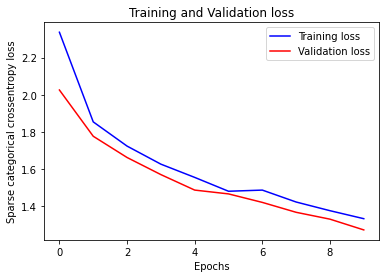

In [ ]:
plot_loss(EPOCHS, loss_train, loss_val)

##### 6.2.9. Inference


In [ ]:
# Use code cells of 6.1.9.

##### 6.2.10. Restore the latest checkpoint and test

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

###### 6.2.10.1. Inference with greedy search

In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, 
        enc_in_image_test, dec_in_test, 'random')


Question: does this calculator have built in computer algebra system
Actual answer: no
Predicted answer: yes

Question: can you use this pot on a glass top stove
Actual answer: absolutely tony
Predicted answer: yes

Question: does it have a mic
Actual answer: sorry no
Predicted answer: yes

Question: mix 1 1 of what cold milk or cold water
Actual answer: water
Predicted answer: yes

Question: how many watts thanks
Actual answer: its battery operated
Predicted answer: about 3 feet

Question: is there a magnet on the back of this item
Actual answer: yes
Predicted answer: yes

Question: are thre three individual temperature settings
Actual answer: yes works great
Predicted answer: yes

Question: will these headphones fit children
Actual answer: they might
Predicted answer: yes

Question: is this mic silver or black
Actual answer: silver
Predicted answer: yes

Question: is this wind up or battery
Actual answer: wind up
Predicted answer: yes


In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, 
        enc_in_image_test, dec_in_test, 'random', count=1, special_input=True)


Question: All zeros
Actual answer: no
Predicted answer: 


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(encoder, decoder, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus')
timer(start_time)

Time taken: 0 hours 0 minutes and 47.96 seconds.


###### 6.2.10.2. Inference with beam search

In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, 
        enc_in_image_test, dec_in_test, 'random', beam_search=True)


Question: can it be used for an iphone 3gs
Actual answer: no
Predicted answer: yes

Question: does the color look black or brown
Actual answer: black
Predicted answer: yes

Question: what color is the inside
Actual answer: black
Predicted answer: about

Question: how thick is this seat
Actual answer: roughly 3 4
Predicted answer: about

Question: latin american or european pronunciation
Actual answer: latin american
Predicted answer: yes

Question: can this be mounted to a tripod
Actual answer: nope
Predicted answer: yes

Question: is this really 71 inches tall
Actual answer: yes indeed
Predicted answer: yes

Question: is it small enough to use on eyeglasses
Actual answer: yes it is
Predicted answer: yes

Question: how much power does this draw
Actual answer: 15 amps
Predicted answer: about

Question: will it work with an ipod
Actual answer: of course
Predicted answer: yes


In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, 
        enc_in_image_test, dec_in_test, 'random', count=1, special_input=True, 
        beam_search=True)


Question: All zeros
Actual answer: china
Predicted answer: 


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(encoder, decoder, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus', 
                                                    beam_search=True)
timer(start_time)

Time taken: 0 hours 1 minutes and 14.6 seconds.


###### 6.2.10.3. Inference with greedy search (with TF-Lite)

In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', tflite=True, use_quantize_decoder_inputs_order=True)


Question: does the center handle on the pelican 1720 case fold down
Actual answer: yes
Predicted answer: yes

Question: does it sound like a real drumset
Actual answer: yes
Predicted answer: yes

Question: does this cooler have a spigot
Actual answer: yes
Predicted answer: yes

Question: ditto does the racquet xome with case
Actual answer: yes
Predicted answer: yes

Question: what is the length of this diverter spout
Actual answer: 6 1 8
Predicted answer: about 3 feet

Question: is this popcorn pesticide free
Actual answer: yes it is
Predicted answer: yes

Question: it works with clarion cdm6
Actual answer: yes
Predicted answer: yes

Question: does seat and back heat
Actual answer: yes
Predicted answer: yes

Question: do the arms move or permanent
Actual answer: yes they do
Predicted answer: yes

Question: does it count up and down
Actual answer: yes
Predicted answer: yes


In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, tflite=True, 
        use_quantize_decoder_inputs_order=True)


Question: All zeros
Actual answer: 4 to 7psi
Predicted answer: 


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_file, 
                                                    tflite_decoder_model_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus',
                                                    tflite=True,
                                                    use_quantize_decoder_inputs_order=True)
timer(start_time)

Time taken: 0 hours 2 minutes and 19.22 seconds.


###### 6.2.10.4. Inference with beam search (with TF-Lite)

In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', beam_search=True, tflite=True, use_quantize_decoder_inputs_order=True)

In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, beam_search=True, tflite=True,
         use_quantize_decoder_inputs_order=True)

In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_file, 
                                                    tflite_decoder_model_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus', 
                                                    beam_search=True, 
                                                    tflite=True,
                                                    use_quantize_decoder_inputs_order=True)
timer(start_time)

###### 6.2.10.5. Inference with greedy search (with TF-Lite and Post Quantization)

In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', tflite=True, quantize=True)


Question: can be operated during the day
Actual answer: yes it can
Predicted answer: yes

Question: are these noise canceling
Actual answer: no
Predicted answer: yes

Question: can i get facebook on it
Actual answer: yes
Predicted answer: yes

Question: will it work with my cordless 2 speed dremel 7300
Actual answer: no
Predicted answer: yes

Question: would this fit a 1959 gibson archtop l 48
Actual answer: definetly not
Predicted answer: yes

Question: does this phone have a slot for a verizon sim card
Actual answer: yes it does
Predicted answer: yes

Question: is there warranty on this printer
Actual answer: 1 yr
Predicted answer: yes

Question: is this battery rechareable
Actual answer: yes
Predicted answer: yes

Question: what are the dimensions of this rug thanks
Actual answer: 26 x 78
Predicted answer: about 3 feet

Question: how tall is the unit
Actual answer: about 5 tall
Predicted answer: about 3 feet


In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, tflite=True, quantize=True)


Question: All zeros
Actual answer: yes
Predicted answer: 


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_fp16_file, 
                                                    tflite_decoder_model_fp16_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus',
                                                    tflite=True, quantize=True)
timer(start_time)

Time taken: 0 hours 11 minutes and 59.37 seconds.


###### 6.2.10.6. Inference with beam search (with TF-Lite and Post Quantization)

In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', beam_search=True, tflite=True, quantize=True)


Question: does this chair recline
Actual answer: no
Predicted answer: yes

Question: can this reversing module be used on a dcc system
Actual answer: yes
Predicted answer: yes

Question: what are the dimensions
Actual answer: 42x17 2x30 inches
Predicted answer: about

Question: can you see when light is working
Actual answer: absolutely
Predicted answer: yes

Question: what is the measurement
Actual answer: 2 3
Predicted answer: about

Question: hello the voltage and current can be independently adjusted right
Actual answer: yes they can
Predicted answer: yes

Question: is bottom part of curtain a polyester fabric or also vinyl
Actual answer: it is vinyl
Predicted answer: yes

Question: what color is the cord
Actual answer: clear
Predicted answer: about

Question: does this product come with lifetime map updates for the gps
Actual answer: i hope so
Predicted answer: yes

Question: what color is the mat
Actual answer: black
Predicted answer: about


In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, beam_search=True, tflite=True, quantize=True)


Question: All zeros
Actual answer: yes it fits
Predicted answer: 


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_fp16_file, 
                                                    tflite_decoder_model_fp16_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus', 
                                                    beam_search=True, 
                                                    tflite=True, quantize=True)
timer(start_time)

Time taken: 0 hours 12 minutes and 31.93 seconds.


##### 6.2.11. Calculate BLEU Score

###### 6.2.11.1. With greedy search inference

In [ ]:
start_time = timer()
print('BLEU-1: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.25, 0.25, 0.25, 0.25)))
timer(start_time)

BLEU-1: 0.188138
BLEU-2: 0.013439
BLEU-3: 0.007108
BLEU-4: 0.014381
Time taken: 0 hours 0 minutes and 0.15 seconds.


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


###### 6.2.11.2. With beam search inference

In [ ]:
start_time = timer()
print('BLEU-1: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.25, 0.25, 0.25, 0.25)))
timer(start_time)

BLEU-1: 0.182886
BLEU-2: 0.292314
BLEU-3: 0.352629
BLEU-4: 0.369561
Time taken: 0 hours 0 minutes and 0.15 seconds.


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


##### 6.2.12. TensorBoard

In [ ]:
# Code to zip the logs
!zip -rqq logs.zip logs

In [ ]:
# Code to download logs zip
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('logs.zip')

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/gradient_tape/20200720-042440/baseline_mask/

#### 6.3. Attention Model with Masking

##### 6.3.1. Create a tf.data dataset

In [ ]:
# Use code cells of 6.1.1.

##### 6.3.2. Write the encoder and decoder model

###### 6.3.2.1. Custom Masking Layer

In [ ]:
class CustomMaskingLayer(tf.keras.layers.Layer):
    def __init__(self, mask_zero=False, **kwargs):
        super(CustomMaskingLayer, self).__init__(**kwargs)
        self.mask_zero = mask_zero

    def compute_mask(self, inputs, mask=None):
        if not self.mask_zero:
            return None
        return tf.not_equal(inputs, 0.0)

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding_ques = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                                        input_length=max_ques_length, 
                                                        weights=[embedding_matrix], 
                                                        trainable=False, mask_zero=True)
        self.embedding_title = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                                         input_length=max_title_length, 
                                                         weights=[embedding_matrix], 
                                                         trainable=False, mask_zero=True)
        
        self.lstm_ques = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True)
        self.lstm_title = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True)
        
        self.dense_state_h_ques = tf.keras.layers.Dense(int(self.enc_units/2))
        self.dense_state_h_title = tf.keras.layers.Dense(int(self.enc_units/2))
        self.dense_state_c_ques = tf.keras.layers.Dense(int(self.enc_units/2))
        self.dense_state_c_title = tf.keras.layers.Dense(int(self.enc_units/2))

        self.conv2d_image = tf.keras.layers.Conv2D(32, (3, 3), 
                                    activation = 'relu',
                                    kernel_initializer = tf.keras.initializers.HeNormal(seed=SEED),
                                    padding = 'same')
        self.flatten_image = tf.keras.layers.Flatten()
        self.dense_image = tf.keras.layers.Dense(self.enc_units)

        self.dense_price = tf.keras.layers.Dense(self.enc_units)

        
    def call(self, x):   
        question, title, price, image, hidden = x[0], x[1], x[2], x[3], x[4]
        # question shape == (batch_size, max_ques_length)
        # title shape == (batch_size, max_title_length)
        # price shape == (batch_size, 1)
        # image shape == (batch_size, img_width, img_height, channels)

        question_e = self.embedding_ques(question)
        # question_e shape == (batch_size, max_ques_length, embedding_dim)
        question_mask = self.embedding_ques.compute_mask(question)
        # question_mask shape == (batch_size, max_ques_length)
        output_ques, state_h_ques, state_c_ques = self.lstm_ques(question_e, initial_state = hidden, mask=question_mask)
        # output_ques shape == (batch_size, max_ques_length, enc_units)
        # state_h_ques shape == (batch_size, enc_units)
        # state_c_ques shape == (batch_size, enc_units)

        title_e = self.embedding_title(title)
        # title_e shape == (batch_size, max_title_length, embedding_dim)
        title_mask = self.embedding_title.compute_mask(title)
        # title_mask shape == (batch_size, max_title_length)
        output_title, state_h_title, state_c_title = self.lstm_title(title_e, initial_state = hidden, mask=title_mask)
        # output_title shape == (batch_size, max_title_length, enc_units)
        # state_h_title shape == (batch_size, enc_units)
        # state_c_title shape == (batch_size, enc_units)

        price = self.dense_price(price)
        # price shape == (batch_size, enc_units)

        image = self.conv2d_image(image)
        # image shape ==  (batch_size, img_width, img_height, filters=32)
        image = self.flatten_image(image)
        # image shape == (batch_size, 51200)
        image = self.dense_image(image)
        # image shape == (batch_size, enc_units)
        
        output = tf.concat([output_ques, output_title], axis=1)
        # output shape == (batch_size, max_ques_length + max_title_length, enc_units)
        output = tf.concat([tf.expand_dims(price, 1), output], axis=1)
        # output shape == (batch_size, max_ques_length + max_title_length + 1, enc_units)
        output = tf.concat([tf.expand_dims(image, 1), output], axis=1)
        # output shape == (batch_size, max_ques_length + max_title_length + 1 + 1, enc_units)

        state_h_ques = self.dense_state_h_ques(state_h_ques)
        # state_h_ques shape == (batch_size, int(enc_units/2))
        state_h_title = self.dense_state_h_title(state_h_title)
        # state_h_title shape == (batch_size, int(enc_units/2))
        state_h = tf.concat([state_h_ques, state_h_title], axis=-1)
        # state_h shape == (batch_size, enc_units)

        state_c_ques = self.dense_state_c_ques(state_c_ques)
        # state_c_ques shape == (batch_size, int(enc_units/2))
        state_c_title = self.dense_state_c_title(state_c_title)
        # state_c_title shape == (batch_size, int(enc_units/2))
        state_c = tf.concat([state_c_ques, state_c_title], axis=-1)
        # state_c shape == (batch_size, enc_units + enc_units)

        return output, state_h, state_c

    def initialize_hidden_state(self):
        return (tf.zeros((self.batch_sz, self.enc_units)),
                tf.zeros((self.batch_sz, self.enc_units)))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                                   input_length=max_ans_length, 
                                                   weights=[embedding_matrix], 
                                                   trainable=False, mask_zero=True)
        
        self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = tf.keras.layers.AdditiveAttention()

        self.masking_hidden = CustomMaskingLayer(mask_zero=True)
        self.masking_enc_ouput = CustomMaskingLayer(mask_zero=True)
        
    def call(self, y):
        inputs, hidden, enc_output = y[0], y[1], y[2]
        # inputs shape == (batch_size, 1)
        # hidden shape == tuple of two (batch_size, enc_units) [lstm state_h and state_c]
        # enc_output shape == (batch_size, max_ques_length, enc_units)

        # hidden == lstm state_h
 
        hidden_with_time_axis = tf.expand_dims(hidden[0], 1)
        # hidden_with_time_axis shape == (batch_size, 1, enc_units)
        
        mask_hidden = self.masking_hidden(hidden_with_time_axis[:,:,0])
        hidden_with_time_axis_mask = self.masking_hidden.compute_mask(mask_hidden)

        
        # hidden_with_time_axis_mask shape == (batch_size, 1)
        
        mask_enc_output = self.masking_enc_ouput(enc_output[:,:,0])
        enc_output_mask = self.masking_enc_ouput.compute_mask(mask_enc_output)
        
        # enc_output_mask shape == (batch_size, max_ques_length)
        
        
        context_vector = self.attention(inputs=[hidden_with_time_axis, enc_output],
                                        mask=[hidden_with_time_axis_mask, enc_output_mask])
        
        # context_vector shape == (batch_size, 1, enc_units)

        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(inputs)
        
        mask = self.embedding.compute_mask(inputs)
        # mask shape == (batch_size, 1)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([context_vector, x], axis=-1)
        
        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x, initial_state=hidden, mask=mask)
        # output shape == (batch_size, 1, dec_units)
        # state_h shape == (batch_size, dec_units)
        # state_c shape == (batch_size, dec_units)
 
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size * 1, dec_units)
        
        x = self.fc(output)
        # output shape == (batch_size, vocab)
        
        return x, state_h, state_c

    def initialize_hidden_state(self):
        return (tf.zeros((self.batch_sz, self.dec_units)),
                tf.zeros((self.batch_sz, self.dec_units)))

In [ ]:
encoder = Encoder(qa_vocab_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_state_hidden, sample_state_cell = encoder([example_input_ques_batch, example_input_title_batch, example_input_price_batch, example_input_image_batch, sample_hidden])
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder hidden state shape: (batch size, units) {}'.format(sample_state_hidden.shape))
print ('Encoder cell state shape: (batch size, units) {}'.format(sample_state_cell.shape))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Encoder output shape: (batch size, sequence length, units) (32, 26, 1024)
Encoder hidden state shape: (batch size, units) (32, 1024)
Encoder cell state shape: (batch size, units) (32, 1024)


In [ ]:
encoder.summary()

Model: "encoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      multiple                  8872800   
_________________________________________________________________
embedding_6 (Embedding)      multiple                  8872800   
_________________________________________________________________
lstm_5 (LSTM)                multiple                  5427200   
_________________________________________________________________
lstm_6 (LSTM)                multiple                  5427200   
_________________________________________________________________
dense_13 (Dense)             multiple                  524800    
_________________________________________________________________
dense_14 (Dense)             multiple                  524800    
_________________________________________________________________
dense_15 (Dense)             multiple                  52

In [ ]:
decoder = Decoder(qa_vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder([tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output])

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 29576)


In [ ]:
decoder.summary()

Model: "decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      multiple                  8872800   
_________________________________________________________________
lstm_7 (LSTM)                multiple                  9621504   
_________________________________________________________________
dense_19 (Dense)             multiple                  30315400  
_________________________________________________________________
additive_attention (Additive multiple                  1024      
_________________________________________________________________
custom_masking_layer (Custom multiple                  0         
_________________________________________________________________
custom_masking_layer_1 (Cust multiple                  0         
Total params: 48,810,728
Trainable params: 39,937,928
Non-trainable params: 8,872,800
_____________________________________

###### 6.3.2.2. tf.keras.layers.Masking Layer

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding_ques = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                                        input_length=max_ques_length, 
                                                        weights=[embedding_matrix], 
                                                        trainable=False, mask_zero=True)
        self.embedding_title = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                                         input_length=max_title_length, 
                                                         weights=[embedding_matrix], 
                                                         trainable=False, mask_zero=True)
        
        self.lstm_ques = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True)
        self.lstm_title = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True)
        
        self.dense_state_h_ques = tf.keras.layers.Dense(int(self.enc_units/2))
        self.dense_state_h_title = tf.keras.layers.Dense(int(self.enc_units/2))
        self.dense_state_c_ques = tf.keras.layers.Dense(int(self.enc_units/2))
        self.dense_state_c_title = tf.keras.layers.Dense(int(self.enc_units/2))

        self.conv2d_image = tf.keras.layers.Conv2D(32, (3, 3), 
                                    activation = 'relu',
                                    kernel_initializer = tf.keras.initializers.HeNormal(seed=SEED),
                                    padding = 'same')
        self.flatten_image = tf.keras.layers.Flatten()
        self.dense_image = tf.keras.layers.Dense(self.enc_units)

        self.dense_price = tf.keras.layers.Dense(self.enc_units)
        
    def call(self, x):   
        question, title, price, image, hidden = x[0], x[1], x[2], x[3], x[4]
        # question shape == (batch_size, max_ques_length)
        # title shape == (batch_size, max_title_length)
        # price shape == (batch_size, 1)
        # image shape == (batch_size, img_width, img_height, channels)

        question_e = self.embedding_ques(question)
        # question_e shape == (batch_size, max_ques_length, embedding_dim)
        question_mask = self.embedding_ques.compute_mask(question)
        # question_mask shape == (batch_size, max_ques_length)
        output_ques, state_h_ques, state_c_ques = self.lstm_ques(question_e, initial_state = hidden, mask=question_mask)
        # output_ques shape == (batch_size, max_ques_length, enc_units)
        # state_h_ques shape == (batch_size, enc_units)
        # state_c_ques shape == (batch_size, enc_units)

        title_e = self.embedding_title(title)
        # title_e shape == (batch_size, max_title_length, embedding_dim)
        title_mask = self.embedding_title.compute_mask(title)
        # title_mask shape == (batch_size, max_title_length)
        output_title, state_h_title, state_c_title = self.lstm_title(title_e, initial_state = hidden, mask=title_mask)
        # output_title shape == (batch_size, max_title_length, enc_units)
        # state_h_title shape == (batch_size, enc_units)
        # state_c_title shape == (batch_size, enc_units)

        price = self.dense_price(price)
        # price shape == (batch_size, enc_units)

        image = self.conv2d_image(image)
        # image shape ==  (batch_size, img_width, img_height, filters=32)
        image = self.flatten_image(image)
        # image shape == (batch_size, 51200)
        image = self.dense_image(image)
        # image shape == (batch_size, enc_units)
        
        output = tf.concat([output_ques, output_title], axis=1)
        # output shape == (batch_size, max_ques_length + max_title_length, enc_units)
        output = tf.concat([tf.expand_dims(price, 1), output], axis=1)
        # output shape == (batch_size, max_ques_length + max_title_length + 1, enc_units)
        output = tf.concat([tf.expand_dims(image, 1), output], axis=1)
        # output shape == (batch_size, max_ques_length + max_title_length + 1 + 1, enc_units)

        state_h_ques = self.dense_state_h_ques(state_h_ques)
        # state_h_ques shape == (batch_size, int(enc_units/2))
        state_h_title = self.dense_state_h_title(state_h_title)
        # state_h_title shape == (batch_size, int(enc_units/2))
        state_h = tf.concat([state_h_ques, state_h_title], axis=-1)
        # state_h shape == (batch_size, enc_units)

        state_c_ques = self.dense_state_c_ques(state_c_ques)
        # state_c_ques shape == (batch_size, int(enc_units/2))
        state_c_title = self.dense_state_c_title(state_c_title)
        # state_c_title shape == (batch_size, int(enc_units/2))
        state_c = tf.concat([state_c_ques, state_c_title], axis=-1)
        # state_c shape == (batch_size, enc_units + enc_units)

        return output, state_h, state_c


    def initialize_hidden_state(self):
        return (tf.zeros((self.batch_sz, self.enc_units)),
                tf.zeros((self.batch_sz, self.enc_units)))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                                   input_length=max_ans_length, 
                                                   weights=[embedding_matrix], 
                                                   trainable=False, mask_zero=True)
        
        self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = tf.keras.layers.AdditiveAttention()

        self.masking_hidden = tf.keras.layers.Masking()
        self.masking_enc_output = tf.keras.layers.Masking()
        
    def call(self, y):
        inputs, hidden, enc_output = y[0], y[1], y[2]
        # inputs shape == (batch_size, 1)
        # hidden shape == tuple of two (batch_size, enc_units)
        # enc_output shape == (batch_size, max_ques_length, enc_units)

        hidden_with_time_axis = tf.expand_dims(hidden[0], 1)
        # hidden_with_time_axis shape == (batch_size, 1, enc_units)
        
        hidden_with_time_axis_mask = self.masking_hidden(hidden_with_time_axis)
        # hidden_with_time_axis_mask._keras_mask shape == (batch_size, 1)
        
        enc_output_mask = self.masking_enc_output(enc_output)
        # enc_output_mask._keras_mask shape == (batch_size, max_ques_length)
        
        context_vector = self.attention(inputs=[hidden_with_time_axis, enc_output],
                                        mask=[hidden_with_time_axis_mask._keras_mask, enc_output_mask._keras_mask])
        # context_vector shape == (batch_size, 1, enc_units)

        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(inputs)

        mask = self.embedding.compute_mask(inputs)
        # mask shape == (batch_size, 1)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([context_vector, x], axis=-1)
        
        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x, initial_state=hidden, mask=mask)
        # output shape == (batch_size, 1, dec_units)
        # state_h shape == (batch_size, dec_units)
        # state_c shape == (batch_size, dec_units)
 
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size * 1, dec_units)
        
        x = self.fc(output)
        # output shape == (batch_size, vocab)
        
        return x, state_h, state_c

    def initialize_hidden_state(self):
        return (tf.zeros((self.batch_sz, self.dec_units)),
                tf.zeros((self.batch_sz, self.dec_units)))

In [ ]:
encoder = Encoder(qa_vocab_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_state_hidden, sample_state_cell = encoder([example_input_ques_batch, example_input_title_batch, example_input_price_batch, example_input_image_batch, sample_hidden])
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder hidden state shape: (batch size, units) {}'.format(sample_state_hidden.shape))
print ('Encoder cell state shape: (batch size, units) {}'.format(sample_state_cell.shape))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Encoder output shape: (batch size, sequence length, units) (32, 26, 1024)
Encoder hidden state shape: (batch size, units) (32, 1024)
Encoder cell state shape: (batch size, units) (32, 1024)


In [ ]:
encoder.summary()

Model: "encoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     multiple                  8872800   
_________________________________________________________________
embedding_13 (Embedding)     multiple                  8872800   
_________________________________________________________________
lstm_12 (LSTM)               multiple                  5427200   
_________________________________________________________________
lstm_13 (LSTM)               multiple                  5427200   
_________________________________________________________________
dense_28 (Dense)             multiple                  524800    
_________________________________________________________________
dense_29 (Dense)             multiple                  524800    
_________________________________________________________________
dense_30 (Dense)             multiple                  52

In [ ]:
decoder = Decoder(qa_vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder([tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output])

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 29576)


In [ ]:
decoder.summary()

Model: "decoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     multiple                  8872800   
_________________________________________________________________
lstm_14 (LSTM)               multiple                  9621504   
_________________________________________________________________
dense_34 (Dense)             multiple                  30315400  
_________________________________________________________________
additive_attention_4 (Additi multiple                  1024      
_________________________________________________________________
masking_8 (Masking)          multiple                  0         
_________________________________________________________________
masking_9 (Masking)          multiple                  0         
Total params: 48,810,728
Trainable params: 39,937,928
Non-trainable params: 8,872,800
_____________________________________

##### 6.3.3. Define the optimizer and the loss function

###### 6.3.3.1. Custom Masking Layer

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

###### 6.3.3.2. tf.keras.layers.Masking Layer

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

##### 6.3.4. Checkpoints (Object-based saving)

###### 6.3.4.1. Custom Masking Layer

In [ ]:
checkpoint_dir = './attention_one_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

###### 6.3.4.2. tf.keras.layers.Masking Layer

In [ ]:
checkpoint_dir = './attention_two_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

##### 6.3.5. Setup TensorBoard logging

In [ ]:
if not os.path.exists('logs'):
  os.makedirs('logs')

###### 6.3.5.1. Custom Masking Layer

In [ ]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/gradient_tape/' + current_time + '/attention_one'
summary_writer = tf.summary.create_file_writer(log_dir)

###### 6.3.5.2. tf.keras.layers.Masking Layer

In [ ]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/gradient_tape/' + current_time + '/attention_two'
summary_writer = tf.summary.create_file_writer(log_dir)

##### 6.3.6. Training


In [ ]:
EPOCHS = 10

In [ ]:
# train function is defined in 6.1.6.

###### 6.3.6.1. Custom Masking Layer

In [ ]:
@tf.function
def train_step(inp_ques, inp_title, inp_price, inp_img, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_outputs = encoder([inp_ques, inp_title, inp_price, inp_img, enc_hidden])

    enc_output = enc_outputs[0]

    enc_states = enc_outputs[1:]

    dec_state_h, dec_state_c = enc_states

    dec_input = tf.expand_dims([word2id['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_state_h, dec_state_c = \
                      decoder([dec_input, (dec_state_h, dec_state_c), enc_output])

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
start_time = timer()
loss_train, loss_val = train(EPOCHS)
timer(start_time)

----- Training -----
Epoch 1 Batch 0 Loss 8.2365
Epoch 1 Batch 100 Loss 3.7968
Epoch 1 Batch 200 Loss 2.6993
Epoch 1 Batch 300 Loss 2.3093
Epoch 1 Batch 400 Loss 2.0397
Epoch 1 Batch 500 Loss 2.3020
Epoch 1 Batch 600 Loss 2.7019
Epoch 1 Batch 700 Loss 2.3192
Epoch 1 Loss 2.7537
Time taken: 0 hours 1 minutes and 6.56 seconds.
----- Validation -----
Epoch 1 Batch 0 Val-Loss 2.4931
Epoch 1 Batch 40 Val-Loss 2.0495
Epoch 1 Batch 80 Val-Loss 2.4234
Epoch 1 Batch 120 Val-Loss 1.6168
Epoch 1 Batch 160 Val-Loss 2.9156
Epoch 1 Val-Loss 2.4049
Time taken: 0 hours 0 minutes and 12.91 seconds.
----- Training -----
Epoch 2 Batch 0 Loss 2.3724
Epoch 2 Batch 100 Loss 2.4307
Epoch 2 Batch 200 Loss 1.7933
Epoch 2 Batch 300 Loss 2.4730
Epoch 2 Batch 400 Loss 2.1131
Epoch 2 Batch 500 Loss 2.4670
Epoch 2 Batch 600 Loss 1.6742
Epoch 2 Batch 700 Loss 2.2269
Epoch 2 Loss 2.1761
Time taken: 0 hours 0 minutes and 51.62 seconds.
----- Validation -----
Epoch 2 Batch 0 Val-Loss 1.6635
Epoch 2 Batch 40 Val-Loss 1.

###### 6.3.6.2. tf.keras.layers.Masking Layer

In [ ]:
@tf.function
def train_step(inp_ques, inp_title, inp_price, inp_img, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_outputs = encoder([inp_ques, inp_title, inp_price, inp_img, enc_hidden])

    enc_output = enc_outputs[0]

    enc_states = enc_outputs[1:]

    dec_state_h, dec_state_c = enc_states

    dec_input = tf.expand_dims([word2id['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_state_h, dec_state_c = \
                      decoder([dec_input, (dec_state_h, dec_state_c), enc_output])

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
start_time = timer()
loss_train, loss_val = train(EPOCHS)
timer(start_time)

----- Training -----
Epoch 1 Batch 0 Loss 8.2331
Epoch 1 Batch 100 Loss 2.5534
Epoch 1 Batch 200 Loss 2.4311
Epoch 1 Batch 300 Loss 2.5925
Epoch 1 Batch 400 Loss 1.9531
Epoch 1 Batch 500 Loss 1.9723
Epoch 1 Batch 600 Loss 2.5470
Epoch 1 Batch 700 Loss 1.5699
Epoch 1 Loss 2.3308
Time taken: 0 hours 1 minutes and 7.05 seconds.
----- Validation -----
Epoch 1 Batch 0 Val-Loss 1.6885
Epoch 1 Batch 40 Val-Loss 2.0142
Epoch 1 Batch 80 Val-Loss 1.3743
Epoch 1 Batch 120 Val-Loss 1.7610
Epoch 1 Batch 160 Val-Loss 2.7137
Epoch 1 Val-Loss 2.0759
Time taken: 0 hours 0 minutes and 12.99 seconds.
----- Training -----
Epoch 2 Batch 0 Loss 1.6003
Epoch 2 Batch 100 Loss 1.6989
Epoch 2 Batch 200 Loss 1.7023
Epoch 2 Batch 300 Loss 1.6475
Epoch 2 Batch 400 Loss 1.6773
Epoch 2 Batch 500 Loss 1.8963
Epoch 2 Batch 600 Loss 2.0308
Epoch 2 Batch 700 Loss 1.5498
Epoch 2 Loss 1.8873
Time taken: 0 hours 0 minutes and 51.76 seconds.
----- Validation -----
Epoch 2 Batch 0 Val-Loss 2.3579
Epoch 2 Batch 40 Val-Loss 2.

##### 6.3.7. Save the model

###### 6.3.7.1. Custom Masking Layer

In [ ]:
encoder.save_weights('attention_one_encoder_weights.h5')
decoder.save_weights('attention_one_decoder_weights.h5')

In [ ]:
!tar cvzf attention_one_checkpoints.tar.gz ./attention_one_checkpoints/checkpoint ./attention_one_checkpoints/ckpt-1.data-00000-of-00001 ./attention_one_checkpoints/ckpt-1.index ./attention_one_encoder_weights.h5 ./attention_one_decoder_weights.h5

./attention_one_checkpoints/checkpoint
./attention_one_checkpoints/ckpt-1.data-00000-of-00001
./attention_one_checkpoints/ckpt-1.index
./attention_one_encoder_weights.h5
./attention_one_decoder_weights.h5


In [ ]:
ENC_SAVED_MODEL_DIR = 'attention_one_encoder'
DEC_SAVED_MODEL_DIR = 'attention_one_decoder'
TFLITE_MODELS_DIR = 'attention_one_tflite_models'
ENC_TFLITE_MODEL_NAME = 'attention_one_encoder'
DEC_TFLITE_MODEL_NAME = 'attention_one_decoder'
ENC_TFLITE_QUANTIZED_MODEL_NAME = 'attention_one_encoder_f16'
DEC_TFLITE_QUANTIZED_MODEL_NAME = 'attention_one_decoder_f16'

In [ ]:
encoder.save(ENC_SAVED_MODEL_DIR)
decoder.save(DEC_SAVED_MODEL_DIR)

INFO:tensorflow:Assets written to: attention_one_encoder/assets


INFO:tensorflow:Assets written to: attention_one_encoder/assets


INFO:tensorflow:Assets written to: attention_one_decoder/assets


INFO:tensorflow:Assets written to: attention_one_decoder/assets


In [ ]:
tflite_models_dir = prepare_tflite_models_dir(TFLITE_MODELS_DIR)
tflite_encoder_model_file = convert_saved_model_to_tflite(ENC_SAVED_MODEL_DIR, tflite_models_dir, ENC_TFLITE_MODEL_NAME)
tflite_decoder_model_file = convert_saved_model_to_tflite(DEC_SAVED_MODEL_DIR, tflite_models_dir, DEC_TFLITE_MODEL_NAME)
tflite_encoder_model_fp16_file = convert_saved_model_to_tflite(ENC_SAVED_MODEL_DIR, tflite_models_dir, ENC_TFLITE_QUANTIZED_MODEL_NAME, quantize=True)
tflite_decoder_model_fp16_file = convert_saved_model_to_tflite(DEC_SAVED_MODEL_DIR, tflite_models_dir, DEC_TFLITE_QUANTIZED_MODEL_NAME, quantize=True)

In [ ]:
# Print tf-lite model sizes
!ls -lh {tflite_models_dir}

total 822M
-rw-r--r-- 1 root root 223M Aug 15 15:12 attention_one_decoder
-rw-r--r-- 1 root root 112M Aug 15 15:13 attention_one_decoder_f16
-rw-r--r-- 1 root root 325M Aug 15 15:12 attention_one_encoder
-rw-r--r-- 1 root root 163M Aug 15 15:13 attention_one_encoder_f16


###### 6.3.7.2. tf.keras.layers.Masking Layer

In [ ]:
encoder.save_weights('attention_two_encoder_weights.h5')
decoder.save_weights('attention_two_decoder_weights.h5')

In [ ]:
!tar cvzf attention_two_checkpoints.tar.gz ./attention_two_checkpoints/checkpoint ./attention_two_checkpoints/ckpt-1.data-00000-of-00001 ./attention_two_checkpoints/ckpt-1.index ./attention_two_encoder_weights.h5 ./attention_two_decoder_weights.h5

./attention_two_checkpoints/checkpoint
./attention_two_checkpoints/ckpt-1.data-00000-of-00001
./attention_two_checkpoints/ckpt-1.index
./attention_two_encoder_weights.h5
./attention_two_decoder_weights.h5


In [ ]:
!tar xvzf attention_two_checkpoints.tar.gz ./attention_two_checkpoints

./attention_two_checkpoints/checkpoint
./attention_two_checkpoints/ckpt-15.data-00000-of-00001
./attention_two_checkpoints/ckpt-15.index


In [ ]:
ENC_SAVED_MODEL_DIR = 'attention_two_encoder'
DEC_SAVED_MODEL_DIR = 'attention_two_decoder'
TFLITE_MODELS_DIR = 'attention_two_tflite_models'
ENC_TFLITE_MODEL_NAME = 'attention_two_encoder'
DEC_TFLITE_MODEL_NAME = 'attention_two_decoder'
ENC_TFLITE_QUANTIZED_MODEL_NAME = 'attention_two_encoder_f16'
DEC_TFLITE_QUANTIZED_MODEL_NAME = 'attention_two_decoder_f16'

In [ ]:
# This code cell does not work as of tf-nightly 2.4.0-dev20200815
encoder.save(ENC_SAVED_MODEL_DIR)
decoder.save(DEC_SAVED_MODEL_DIR)

In [ ]:
tflite_models_dir = prepare_tflite_models_dir(TFLITE_MODELS_DIR)
tflite_encoder_model_file = convert_saved_model_to_tflite(ENC_SAVED_MODEL_DIR, tflite_models_dir, ENC_TFLITE_MODEL_NAME)
tflite_decoder_model_file = convert_saved_model_to_tflite(DEC_SAVED_MODEL_DIR, tflite_models_dir, DEC_TFLITE_MODEL_NAME)
tflite_encoder_model_fp16_file = convert_saved_model_to_tflite(ENC_SAVED_MODEL_DIR, tflite_models_dir, ENC_TFLITE_QUANTIZED_MODEL_NAME, quantize=True)
tflite_decoder_model_fp16_file = convert_saved_model_to_tflite(DEC_SAVED_MODEL_DIR, tflite_models_dir, DEC_TFLITE_QUANTIZED_MODEL_NAME, quantize=True)

In [ ]:
# Print tf-lite model sizes
!ls -lh {tflite_models_dir}

##### 6.3.8. Plot the model's loss

In [ ]:
# plot_loss function is defined in 6.1.8.

###### 6.3.8.1. Custom Masking Layer

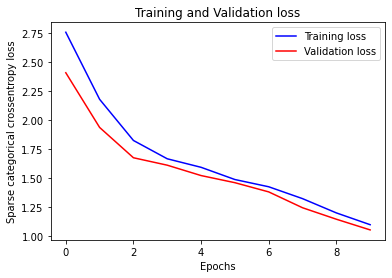

In [ ]:
plot_loss(EPOCHS, loss_train, loss_val)

###### 6.3.8.2. tf.keras.layers.Masking Layer

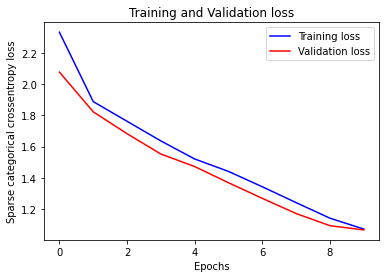

In [ ]:
plot_loss(EPOCHS, loss_train, loss_val)

##### 6.3.9. Inference


In [ ]:
# Use code cells of 6.1.9.

##### 6.3.10. Restore the latest checkpoint and test (Custom Masking Layer)

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

###### 6.3.10.1. Inference with greedy search

In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, 
        enc_in_image_test, dec_in_test, 'random')


Question: can the hammer function be turned off
Actual answer: yes it ca
Predicted answer: yes

Question: is it for iphone 5
Actual answer: no its not
Predicted answer: yes

Question: does it have button or zipper closure
Actual answer: zipper
Predicted answer: yes

Question: is the color a gloss black or matte black
Actual answer: matte black
Predicted answer: yes

Question: is 69in the length or the height
Actual answer: height
Predicted answer: yes

Question: how much power does this draw
Actual answer: 15 amps
Predicted answer: about 2

Question: does product come with a warranty
Actual answer: one year
Predicted answer: yes

Question: hood comes with this lens
Actual answer: yes it does
Predicted answer: yes

Question: does this work with the gopro hero4 black
Actual answer: no
Predicted answer: yes

Question: latin american or european pronunciation
Actual answer: latib american
Predicted answer: yes


In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, 
        enc_in_image_test, dec_in_test, 'random', count=1, special_input=True)


Question: All zeros
Actual answer: yes
Predicted answer: 


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(encoder, decoder, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus')
timer(start_time)

Time taken: 0 hours 0 minutes and 51.73 seconds.


###### 6.3.10.2. Inference with beam search

In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, 
        enc_in_image_test, dec_in_test, 'random', beam_search=True)


Question: is this an auto open umbrella
Actual answer: yes
Predicted answer: yes

Question: what is the biggest turkey this will cook
Actual answer: 20lbs
Predicted answer: 120

Question: can you use this pot on a glass top stove
Actual answer: absolutely tony
Predicted answer: yes

Question: how many shells does the gun hold
Actual answer: 6
Predicted answer: about

Question: will this work on a keller 250 pound kkl 16 ladder
Actual answer: no
Predicted answer: yes

Question: is this toy actually out yet
Actual answer: yup
Predicted answer: yes

Question: does this have a seatbelt for younger kids
Actual answer: no seat belts
Predicted answer: yes

Question: is there warranty on this printer
Actual answer: do not knw
Predicted answer: yes

Question: how deep are the containers
Actual answer: 3
Predicted answer: about

Question: will they fit the nutri bullet 600 and the 900
Actual answer: no
Predicted answer: yes


In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, 
        enc_in_image_test, dec_in_test, 'random', count=1, special_input=True, 
        beam_search=True)


Question: All zeros
Actual answer: no
Predicted answer: 


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(encoder, decoder, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus', 
                                                    beam_search=True)
timer(start_time)

Time taken: 0 hours 1 minutes and 26.83 seconds.


###### 6.3.10.3. Inference with greedy search (with TF-Lite)

In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', tflite=True)


Question: are you able to keep the white folio clean
Actual answer: impossible
Predicted answer: yes

Question: how much does the dyson dc65 weigh when it is assembled
Actual answer: 17 lbs
Predicted answer: about 2 lbs

Question: does this have a seatbelt for younger kids
Actual answer: no seat belts
Predicted answer: yes

Question: where are these straws made
Actual answer: china
Predicted answer: china

Question: gaskets included
Actual answer: yes they are
Predicted answer: no

Question: does it come with a tray inside
Actual answer: nope
Predicted answer: yes

Question: will this work in france and london
Actual answer: for sure
Predicted answer: yes

Question: what is the voltage of the oven
Actual answer: 120vac
Predicted answer: 120

Question: will this headset work on xbox 360 ps4 and laptop computer
Actual answer: yes
Predicted answer: yes

Question: is the tire the type that needs inflating
Actual answer: no
Predicted answer: yes


In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, tflite=True)


Question: All zeros
Actual answer: yes
Predicted answer: 


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_file, 
                                                    tflite_decoder_model_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus',
                                                    tflite=True)
timer(start_time)

Time taken: 0 hours 2 minutes and 24.62 seconds.


###### 6.3.10.4. Inference with beam search (with TF-Lite)

In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', beam_search=True, tflite=True)


Question: can the sound music voice be heard through the tv
Actual answer: yes
Predicted answer: yes

Question: does this have twist rudder
Actual answer: no
Predicted answer: yes

Question: does this board come assembled
Actual answer: yes 100
Predicted answer: yes

Question: how much power does this draw
Actual answer: 15 amps
Predicted answer: about

Question: exact size
Actual answer: 12 x 12
Predicted answer: no

Question: does this also transmit audio
Actual answer: yes
Predicted answer: yes

Question: can it make copies
Actual answer: no
Predicted answer: yes

Question: will this be good in a class room for teachers
Actual answer: yes very good
Predicted answer: yes

Question: will this work with an ifrogz case for an ipad mini
Actual answer: doubt it
Predicted answer: yes

Question: will this headset work on xbox 360 ps4 and laptop computer
Actual answer: yes
Predicted answer: yes


In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, beam_search=True, tflite=True)


Question: All zeros
Actual answer: yes
Predicted answer: 


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_file, 
                                                    tflite_decoder_model_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus', 
                                                    beam_search=True, 
                                                    tflite=True)
timer(start_time)

Time taken: 0 hours 3 minutes and 8.59 seconds.


###### 6.3.10.5. Inference with greedy search (with TF-Lite and Post Quantization)

In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', tflite=True, quantize=True)


Question: is the interior stainless steel
Actual answer: yes it is
Predicted answer: 

Question: are the spark plug sockets magnetized
Actual answer: no
Predicted answer: 

Question: does magnets stick to this
Actual answer: yes they do
Predicted answer: 

Question: what is the measurements on the table
Actual answer: 20 squared
Predicted answer: 

Question: are these for females
Actual answer: yes
Predicted answer: 

Question: are these the kernals or in the shell
Actual answer: in the shell
Predicted answer: 

Question: can i use this wagner 0525032 with water base paint
Actual answer: yes
Predicted answer: 

Question: does this also transmit audio
Actual answer: yes
Predicted answer: 

Question: what is the expiration date thanks
Actual answer: april 25 2014
Predicted answer: 

Question: is there a sd card slot
Actual answer: sure
Predicted answer: 


In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, tflite=True, quantize=True)


Question: All zeros
Actual answer: no
Predicted answer: 


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_fp16_file, 
                                                    tflite_decoder_model_fp16_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus',
                                                    tflite=True, quantize=True)
timer(start_time)

Time taken: 0 hours 11 minutes and 53.9 seconds.


###### 6.3.10.6. Inference with beam search (with TF-Lite and Post Quantization)

In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', beam_search=True, tflite=True, quantize=True)


Question: does this come with the supply lines that feed the spider
Actual answer: no lines
Predicted answer: sixaxis sixaxis sixaxis

Question: would this work on tarnished kitchen utensils
Actual answer: no
Predicted answer: sixaxis sixaxis sixaxis

Question: is the inside bottom smooth
Actual answer: yup
Predicted answer: sixaxis sixaxis sixaxis

Question: are these wireless
Actual answer: no
Predicted answer: sixaxis sixaxis sixaxis

Question: where is the country of origin
Actual answer: japan i believe
Predicted answer: sixaxis sixaxis sixaxis

Question: will these headphones fit children
Actual answer: they might
Predicted answer: sixaxis sixaxis sixaxis

Question: will this fit 9x3 50x4 tires
Actual answer: yes
Predicted answer: sixaxis sixaxis sixaxis

Question: the phone is gsm or cdma only
Actual answer: cdma
Predicted answer: sixaxis sixaxis sixaxis

Question: is the tube glass or plastic
Actual answer: plastic regards
Predicted answer: sixaxis sixaxis sixaxis

Question: w

In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, beam_search=True, tflite=True, quantize=True)


Question: All zeros
Actual answer: no
Predicted answer: sixaxis sixaxis sixaxis


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_fp16_file, 
                                                    tflite_decoder_model_fp16_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus', 
                                                    beam_search=True, 
                                                    tflite=True, quantize=True)
timer(start_time)

Time taken: 0 hours 14 minutes and 0.37 seconds.


##### 6.3.11. Restore the latest checkpoint and test (tf.keras.layers.Masking Layer)

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

###### 6.3.11.1. Inference with greedy search

In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, 
        enc_in_image_test, dec_in_test, 'random')


Question: does it work while the device is charging
Actual answer: oh yes beautifully
Predicted answer: yes

Question: are these expired
Actual answer: no
Predicted answer: no

Question: can i buy just the bearing without the hub assembly
Actual answer: nope
Predicted answer: yes

Question: will this fit my 2012 switchback
Actual answer: yes
Predicted answer: yes

Question: so this does not have the diamond rods with it
Actual answer: nope
Predicted answer: yes

Question: does this canopy come with the sidewall shown
Actual answer: yes
Predicted answer: yes

Question: can this use regular batteries as well as the rechargeable ones
Actual answer: no
Predicted answer: yes

Question: are the paddles on the new auger
Actual answer: yes comes complete
Predicted answer: yes

Question: are they made in the usa
Actual answer: made in china
Predicted answer: yes

Question: how many players
Actual answer: 2 6 players
Predicted answer: mp mp


In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, 
        enc_in_image_test, dec_in_test, 'random', count=1, special_input=True)


Question: All zeros
Actual answer: yes
Predicted answer: 


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(encoder, decoder, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus')
timer(start_time)

Time taken: 0 hours 0 minutes and 33.34 seconds.


###### 6.3.11.2. Inference with beam search

In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, 
        enc_in_image_test, dec_in_test, 'random', beam_search=True)


Question: is it really from noble collection
Actual answer: yes
Predicted answer: yes

Question: is the tire the type that needs inflating
Actual answer: no
Predicted answer: no

Question: flattering
Actual answer: i think so
Predicted answer: i

Question: will it fit an hp pavilion dv6 7014nr
Actual answer: no
Predicted answer: yes

Question: will this fit a 2011 toyota tundra
Actual answer: yes
Predicted answer: yes

Question: does this phone have to have a plan with at t
Actual answer: no
Predicted answer: no

Question: does this cooler have a spigot
Actual answer: yes
Predicted answer: no

Question: does it swivel
Actual answer: no
Predicted answer: yes

Question: so where is this kettle made before i place my order
Actual answer: japan i think
Predicted answer: china

Question: can i used this for my galaxy note edge
Actual answer: yes
Predicted answer: yes


In [ ]:
predict(encoder, decoder, enc_in_ques_test, enc_in_title_test, enc_in_price_test, 
        enc_in_image_test, dec_in_test, 'random', count=1, special_input=True, 
        beam_search=True)


Question: All zeros
Actual answer: 120
Predicted answer: 


In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(encoder, decoder, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus', 
                                                    beam_search=True)
timer(start_time)

Time taken: 0 hours 0 minutes and 59.38 seconds.


###### 6.3.11.3. Inference with greedy search (with TF-Lite)

In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', tflite=True)

In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, tflite=True)

In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_file, 
                                                    tflite_decoder_model_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus',
                                                    tflite=True)
timer(start_time)

###### 6.3.11.4. Inference with beam search (with TF-Lite)

In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', beam_search=True, tflite=True)

In [ ]:
predict(tflite_encoder_model_file, tflite_decoder_model_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, beam_search=True, tflite=True)

In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_file, 
                                                    tflite_decoder_model_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus', 
                                                    beam_search=True, 
                                                    tflite=True)
timer(start_time)

###### 6.3.11.5. Inference with greedy search (with TF-Lite and Post Quantization)

In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', tflite=True, quantize=True)

In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, tflite=True, quantize=True)

In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_fp16_file, 
                                                    tflite_decoder_model_fp16_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus',
                                                    tflite=True, quantize=True)
timer(start_time)

###### 6.3.11.6. Inference with beam search (with TF-Lite and Post Quantization)

In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', beam_search=True, tflite=True, quantize=True)

In [ ]:
predict(tflite_encoder_model_fp16_file, tflite_decoder_model_fp16_file, enc_in_ques_test, 
        enc_in_title_test, enc_in_price_test, enc_in_image_test, dec_in_test, 
        'random', count=1, special_input=True, beam_search=True, tflite=True, quantize=True)

In [ ]:
start_time = timer()
predicted_answer_list, actual_answer_list = predict(tflite_encoder_model_fp16_file, 
                                                    tflite_decoder_model_fp16_file, 
                                                    enc_in_ques_test, 
                                                    enc_in_title_test, 
                                                    enc_in_price_test, 
                                                    enc_in_image_test, 
                                                    dec_in_test, 'corpus', 
                                                    beam_search=True, 
                                                    tflite=True, quantize=True)
timer(start_time)

##### 6.3.12. Calculate BLEU Score (Custom Masking Layer)

###### 6.3.12.1. With greedy search inference

In [ ]:
start_time = timer()
print('BLEU-1: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.25, 0.25, 0.25, 0.25)))
timer(start_time)

BLEU-1: 0.283994
BLEU-2: 0.075399
BLEU-3: 0.046779
BLEU-4: 0.074845
Time taken: 0 hours 0 minutes and 0.17 seconds.


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


###### 6.3.12.2. With beam search inference

In [ ]:
start_time = timer()
print('BLEU-1: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.25, 0.25, 0.25, 0.25)))
timer(start_time)

BLEU-1: 0.203827
BLEU-2: 0.308597
BLEU-3: 0.364286
BLEU-4: 0.379713
Time taken: 0 hours 0 minutes and 0.17 seconds.


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


##### 6.3.13. Calculate BLEU Score (tf.keras.layers.Masking Layer)

###### 6.3.13.1. With greedy search inference

In [ ]:
start_time = timer()
print('BLEU-1: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.25, 0.25, 0.25, 0.25)))
timer(start_time)

BLEU-1: 0.228777
BLEU-2: 0.039098
BLEU-3: 0.015423
BLEU-4: 0.028999
Time taken: 0 hours 0 minutes and 0.17 seconds.


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


###### 6.3.13.2. With beam search inference

In [ ]:
start_time = timer()
print('BLEU-1: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual_answer_list, predicted_answer_list, weights=(0.25, 0.25, 0.25, 0.25)))
timer(start_time)

BLEU-1: 0.194456
BLEU-2: 0.314775
BLEU-3: 0.381656
BLEU-4: 0.400489
Time taken: 0 hours 0 minutes and 0.15 seconds.


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


##### 6.3.12. TensorBoard

In [ ]:
# Code to zip the logs
!zip -rqq logs.zip logs

In [ ]:
!tar cvzf logs.tar.gz logs/

In [ ]:
# Code to download logs zip
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('logs.zip')

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/gradient_tape/20200719-064637/attention_two/

### 7. Tabulated Results

Iteration-I Models - Index 01 to 08

Iteration-II Models - Index 09 to 16

In [ ]:
from prettytable import PrettyTable
 
x = PrettyTable()

x.field_names = ["Index", "Model", "Features", "Epochs", "Loss", "Val-Loss", "BLEU Score"]
x.add_row(["01", "Baseline", "No Masking + Greedy Search Inference", 10, "01.0581", "01.0331", "07.5227"])
x.add_row(["02", "Baseline", "Masking + Greedy Search Inference", 10, "01.0487", "01.0106", "03.6751"])
x.add_row(["03", "Attention", "Bahdanau + Custom Masking Layer + Greedy Search Inference", 10, "01.0039", "00.9739", "05.5855"])
x.add_row(["04", "Attention", "Bahdanau + Masking Layer + Greedy Search Inference", 10, "01.3435", "01.3068", "12.4567"])
x.add_row(["--", "---------", "---------------------------------------------------------------------------", "--", "------", "------", "------"])
x.add_row(["05", "Baseline", "No Masking + Beam Search Inference", 10, "01.0581", "01.0331", "35.8249"])
x.add_row(["06", "Baseline", "Masking + Beam Search Inference", 10, "01.0487", "01.0106", "35.6468"])
x.add_row(["07", "Attention", "Bahdanau + Custom Masking Layer + Beam Search Inference", 10, "01.0039", "00.9739", "35.7717"])
x.add_row(["08", "Attention", "Bahdanau + Masking Layer + Beam Search Inference", 10, "01.3435", "01.3068", "35.9478"])
x.add_row(["--", "---------", "---------------------------------------------------------------------------", "--", "------", "------", "------"])
x.add_row(["09", "Baseline", "Extra Features + No Masking + Greedy Search Inference", 10, "01.4932", "01.4320", "36.5983"])
x.add_row(["10", "Baseline", "Extra Features + Masking + Greedy Search Inference", 10, "01.3331", "01.2727", "01.4381"])
x.add_row(["11", "Attention", "Extra Features + Bahdanau + Custom Masking Layer + Greedy Search Inference", 10, "01.0962", "01.0513", "07.4845"])
x.add_row(["12", "Attention", "Extra Features + Bahdanau + Masking Layer + Greedy Search Inference", 10, "01.0726", "01.0672", "02.8999"])
x.add_row(["--", "---------", "---------------------------------------------------------------------------", "--", "------", "------", "------"])
x.add_row(["13", "Baseline", "New Features + No Masking + Beam Search Inference", 10, "01.4932", "01.4320", "36.5983"])
x.add_row(["14", "Baseline", "New Features + Masking + Beam Search Inference", 10, "01.3331", "01.2727", "36.9561"])
x.add_row(["15", "Attention", "New Features + Bahdanau + Custom Masking Layer + Beam Search Inference", 10, "01.0962", "01.0513", "37.9713"])
x.add_row(["16", "Attention", "New Features + Bahdanau + Masking Layer + Beam Search Inference", 10, "01.0726", "01.0672", "40.0489"])


print(x)

+-------+-----------+-----------------------------------------------------------------------------+--------+---------+----------+------------+
| Index |   Model   |                                   Features                                  | Epochs |   Loss  | Val-Loss | BLEU Score |
+-------+-----------+-----------------------------------------------------------------------------+--------+---------+----------+------------+
|   01  |  Baseline |                     No Masking + Greedy Search Inference                    |   10   | 01.0581 | 01.0331  |  07.5227   |
|   02  |  Baseline |                      Masking + Greedy Search Inference                      |   10   | 01.0487 | 01.0106  |  03.6751   |
|   03  | Attention |          Bahdanau + Custom Masking Layer + Greedy Search Inference          |   10   | 01.0039 | 00.9739  |  05.5855   |
|   04  | Attention |              Bahdanau + Masking Layer + Greedy Search Inference             |   10   | 01.3435 | 01.3068  |  12.4567   |

### 8. Model Inferencing

In [ ]:
!python ./src/main.py 'Are these hex head screws?' 'Dynamite screw set slash stampede rustler bandit' '$25.99' 'https://images-na.ssl-images-amazon.com/images/I/41qZd9n61AL._SX38_SY50_CR,0,0,38,50_.jpg'

2020-08-14 04:46:36.740003: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-08-14 04:46:39.287768: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-08-14 04:46:39.287827: I tensorflow/compiler/jit/xla_gpu_device.cc:69] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-08-14 04:46:39.289021: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-08-14 04:46:39.292324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-08-14 04:46:39.293069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 device